In [137]:
from astropy import units
from astroquery.gaia import Gaia
from astropy.io.votable import parse
from astropy.timeseries import LombScargle
import pymc3 as pm
import arviz as az
from arviz import plot_trace as traceplot
import corner
import pandas as pd
import random
from joblib import Memory
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline
import matplotlib.colors as col
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.figure as fig
from pylab import rcParams
import dustmaps.sfd
from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.config import config
config['data_dir'] = ''
dustmaps.sfd.fetch()

rcParams["figure.figsize"] = (11.4, 7.2)
rcParams["font.family"] = "STIXgeneral"
rcParams["font.size"] = 13.0

location = './lc_data'
location2 = './table_data'
lc_data = Memory(location, verbose=0)
table_data = Memory(location2, verbose=0)

 64.0 MiB of 64.0 MiB |  45.3 MiB/s |###################| 100% | ETA:  00:00:00

 63.2 MiB of 64.0 MiB |  19.6 MiB/s |################## |  98% | ETA:   0:00:00

In [3]:
'''

Function that queries the Gaia Archive either synchronously or asynchronously

Inputs:
query: query to be used by Gaia.launch_job
num_returned: expected number of results to be returned

Outputs:
query results in table format

'''

def gaia_query(query: str, async_bool = None):
    
    if async_bool:
        
        return Gaia.launch_job_async(query).get_results()
    
    else:
        
        return Gaia.launch_job(query).get_results()
    
gaia_query = lc_data.cache(gaia_query)

In [4]:
'''

Function that takes in a url and outputs an xml table

Inputs:
url: string of an ESA website for light curve data of a star

Outputs:
an xml table to be manipulated

'''

def xml_file_parse(url: str):

    return parse(url).get_first_table()

In [5]:
'''

Function that takes in gaia query results, grabs the url associated with the source id
runs a parser to obtain an xml table, and then runs through the table outputting light curve data
as a list of dictionaries

Inputs:
table_list: list of xml tables

Outputs
data_table: list of dictionaries where each dictionary is the xml table data for that
            light curve with field ids from that table as the keys

'''

def organize_data(data):
    
    data_table = []
    
    for url, source_id in zip(data['epoch_photometry_url'], data['source_id']):

        data_dict = {}
        
        xml_table = xml_file_parse(url)
        table_arr = xml_table.array
        
        j = 0
        
        for field in xml_table.fields:
            
            data_dict[f'{field.ID}'] = []
            
            if field.ID == 'source_id':
                
                data_dict[f'{field.ID}'] = table_arr[0][0]
                
                j+=1
                
            elif field.ID == 'solution_id':
                
                data_dict[f'{field.ID}'] = table_arr[0][-1]
                
            else:
                
                for i in range(len(table_arr)):

                    data_dict[f'{field.ID}'].append(table_arr[i][j])

                j+=1
                
        data_table.append(data_dict)
            
    return data_table

In [6]:
'''

Function that takes in list of dictionaries of light curve data, runs through each dictionary,
grabs flux, flux errors, times, and magnitudes associated with the G band

Inputs:
data: list of dictionaries as returned by organize_data

Outputs:
dictionary of lists where each list is the data associated with one star

'''

def periodogram_data(data: list):
    
    flux_data = []
    flux_err_data = []
    time_data = []
    mag_data = []
     
    for i in range(len(data)):
        
        flux = []
        flux_err = []
        time = []
        mag = []
        
        for j in range(len(data[i]['band'])):
        
            if data[i]['band'][j] == 'G':

                flux.append(data[i]['flux'][j])
                flux_err.append(data[i]['flux_error'][j])
                time.append(data[i]['time'][j])
                mag.append(data[i]['mag'][j])
            
        flux_data.append(flux)
        flux_err_data.append(flux_err)
        time_data.append(time)
        mag_data.append(mag)
    
    return {'flux_g': np.array(flux_data, dtype=object), 'flux_err_g': np.array(flux_err_data, dtype=object),
            'time_g': np.array(time_data, dtype=object), 'mag_g': np.array(mag_data, dtype=object)}

In [7]:
'''

Function that takes in periodogram dictionary and list of periods and returns time in phase

Inputs:
periodogram_ds: dictionary as returned by periodogram_data
period: list of periods 

Outputs:
list of times in terms of phase for each star

'''

def create_phase(periodogram_ds: dict, period: list):    
    
    phase_tot = []

    for j in range(len(periodogram_ds['time_g'])):

        phase = []

        for val in periodogram_ds['time_g'][j]:

            phase.append(val % period[j])

        phase_tot.append(phase)
        
    return np.array(phase_tot, dtype=object)

In [8]:
'''

Function that takes in a number of terms to compute for a fourier series expansion
and returns the coefficients in a fourier series expansion

Inputs:
N: number of cosine and sine terms

'''

def make_fourier(N: int):
    
    def fourier(x, *a):
        
        fourier_sum = 0.0
        term_num = 0
        k = 0
        
        while k < N+1:

            fourier_sum += a[term_num] * np.cos(k * (2 * np.pi / prd) * x)
            term_num+=1
        
            fourier_sum += a[term_num] * np.sin(k * (2 * np.pi / prd) * x)
            term_num+=1
            k+=1
            
        return fourier_sum
    
    return fourier

In [9]:
'''

Function that takes in a parameter for the mean and outputs a new proposal mean
of a gaussian

Input:
x: current mean

Output:
proposal mean

'''

def gaussian(x):
    
    step_size = 0.238
    
    return x + np.random.normal(0, step_size)

'''

Function that returns log-likelihood of a normal distribution centered
at mu=1 and sigma=0.1 based upon a proposal mean

Input:
x: input mean

Output:
log-likelihood of the input mean

'''

def ln_gauss_llh(x):
    
    if -5 < x < 5:
        
        return -(x - 1)**2/(2*0.1**2)
    
    else:
        
        return 10**(-6)
    
'''

Metropolis-Hastings Markov Chain Monte Carlo sampler which samples from a
one-dimensional posterior through a random walk in parameter space thus creating
a markov chain of successful walks

Input:
proposal: function which proposes a step to talk in parameter space
likelihood: function from which to calculate the likelihood of the candidate
parameter being the optimal parameter
x0: initial starting point for the walk
iters: number of iterations in the chain
burn_in: number of chain elements to exclude from the final chain

Output:
numpy array of the chain, the log-likelihood, and the acceptance rate
all as functions of step number

'''
    
def mh_mcmc(proposal, likelihood, x0, iters, burn_in):
    
    x_t = np.zeros(iters)
    x_t[0] = x0
    ln_llh = np.zeros(iters)
    acceptance_rate = np.zeros(iters)
    acc = 0
    rej = 0
    t = 1
    
    for t in range(iters-1):
        
        x_cand = proposal(x_t[t])
        
        alpha = np.exp(likelihood(x_cand) - likelihood(x_t[t]))
        
        if np.random.uniform(0, 1) < alpha:
            
            x_t[t+1] = x_cand
            ln_llh[t] = likelihood(x_cand)
            
            if t > burn_in:
                
                acc+=1
                acceptance_rate[t] = acc/(acc+rej)
            
        else:
            
            x_t[t+1] = x_t[t]
            ln_llh[t] = likelihood(x_t[t])
            
            if t > burn_in:
                
                rej+=1
            
    return np.array([x_t, ln_llh, acceptance_rate])

In [10]:
'''

Function that takes in parameters for model M = a*log(P)+b and uses a 
multivariable normal distribution to generate a new vector of parameters

Input:
vector of parameters (a, b, sigma_scatter)

Output:
vector of parameters (a, b, sigma_scatter)

'''

def multivar_gauss(params):
    
    return np.array([params[0]+np.random.normal(0, multivar_params[0]),
                     params[1]+np.random.normal(0, multivar_params[1]),
                     params[2]+np.random.normal(0, multivar_params[2])])

'''

Function that takes in parameter vector, observed data, a model, x_data, and errors
and computes the log likelihood that the model with the given parameters
fits the data

Input:
params: parameter vector (a, b, sigma_scatter)
observed: computed magnitudes of RR Lyrae vector
model: model we wish to compare to observed data
x_data: computed periods of RR Lyrae vector
errors: measurement error vector

Output:
log-likelihood also known as -(chi^2)/2

'''

def likelihood(params, model, x_data, observed, errors):

    return np.sum(-(observed-model(params, x_data))**2/(2*np.sqrt(errors**2+params[2]**2)))


'''

Metropolis-Hastings Markov Chain Monte Carlo simulator function
samples from a posterior distribution by walking in parameter space to different points
via Monte Carlo simulation and creates a Markov Chain of all accepted walking points eventually
landing at a point which minimizes the log-likelihood

Input:
posterior: log-likelihood of a multivariable normal distribution
proposal: function which proposes a new point to walk to in parameter space,
iters: number of iterations in our chain
burn_in: number of initial walking values to discard
x0: beginning point in parameter space
kwargs: arguments for the likelihood function

Output:
a numpy array containing the chain, the acceptance rate, and the log-likelihood
all as a function of step number


'''

def MH_MCMC(posterior, proposal, iters, burn_in, x0, **kwargs):
    
    acceptance_rate = []
    
    if type(x0) == float:
        
        ndim = 1
    
    else:
        
        ndim = len(x0)
        
    log_likelihood = np.zeros(iters)
    
    x_t = np.zeros((iters, ndim))
    
    x_t[0] = x0
    
    acc = 0
    rej = 0
    t = 0
        
    while t < iters-1:

        x_cand = proposal(x_t[t])
        alpha = np.exp((posterior(x_cand, kwargs['model'], kwargs['x_data'], kwargs['observed'], kwargs['errors'])) -
                        (posterior(x_t[t], kwargs['model'], kwargs['x_data'], kwargs['observed'], kwargs['errors'])))

        if np.random.rand() <= alpha:

            x_t[t+1] = x_cand
            log_likelihood[t+1] = posterior(x_t[t+1],kwargs['model'], kwargs['x_data'], kwargs['observed'], kwargs['errors'])

            if t > burn_in:

                acc+=1
                acceptance_rate.append(acc/(acc+rej))

        else:

            x_t[t+1] = x_t[t]
            log_likelihood[t] = posterior(x_t[t+1],kwargs['model'], kwargs['x_data'], kwargs['observed'], kwargs['errors'])

            if t > burn_in:

                rej+=1

        t+=1
    
    return np.array([x_t[burn_in:], acceptance_rate, log_likelihood])

# First Query

We first query Gaia to obtain the first 100 RR Lyrae stars which have a non-zero fundamental pulsation mode value measured in more than 40 clean epochs obtained in the G-band. The reason for this is that we wish to estimate the periods and other attributes of these variables to determine how accurate the Gaia values are so that we may then calculate a period-luminosity relationship. By joining the gaiadr2.vari_rrlyrae table to the gaiadr2.gaia_source table, we obtain the URLs necessary to obtain the raw light-curve data. This will then allow us to perform our analyses.

In [11]:
# query to obtain rr lyrae data

rr_lyrae_data = gaia_query("SELECT TOP 100 * FROM gaiadr2.gaia_source JOIN gaiadr2.vari_rrlyrae USING (source_id) \
WHERE pf != 0 \
AND num_clean_epochs_g > 40;")

In [12]:
# function which allows us to obtain light curve data and organizes it into a data structure

organized_data = organize_data(rr_lyrae_data)

In [13]:
# function which then grabs data necessary for lomb-scargle

periodata = periodogram_data(organized_data)

In [14]:
# manipulating the data so that we can use it for the lomb-scargle periodogram

flux_g = np.array(periodata['flux_g'][6])
flux_err_g = np.array(periodata['flux_err_g'][6])
mean_flux = np.mean(flux_g)
mag_g = periodata['mag_g'][6][0] -2.5*np.log10(flux_g/periodata['flux_g'][6][0])
mag_err_g = np.abs(-2.5*flux_err_g/(2.3*flux_g))
time_g = np.array(periodata['time_g'][6])
s_id = rr_lyrae_data['source_id'][6]

print(periodata['mag_g'][6][0] -2.5*np.log10(mean_flux/periodata['flux_g'][6][0]))

15.033696971234374


We can see below the raw light curve G-band data below. Before we have actually determined the period, we see the sporadic measurements do not give us a clear picture that this data has any sort of relation. To determine the period and obtain a tangible curve, we will use a Lomb-Scargle periodogram which approximates the period by using sine and cosine functions.

Text(0.5, 1.0, 'GDR2 light curve data before phase folding for star: 5813181197970338560')

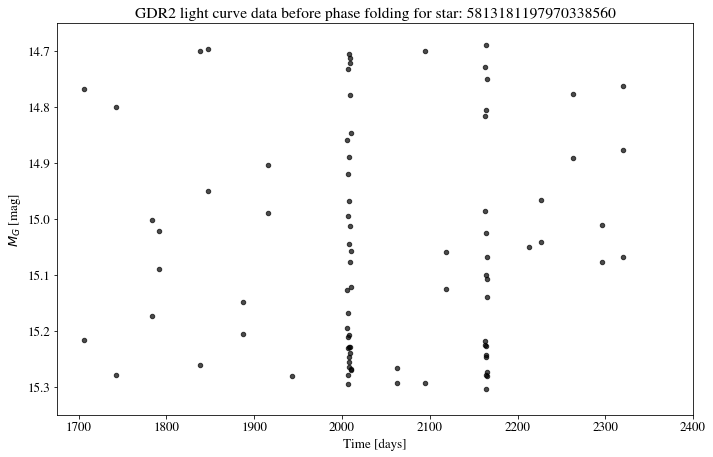

In [15]:
# first plot of the GDR2 light curve data

fig, ax = plt.subplots()

ax.scatter(time_g, mag_g, color='k', alpha=0.7, s=20.0, label='GDR2 Data')

ax.set_xlabel('Time [days]')
ax.set_xticks(np.linspace(1700, 2400, 8))

ax.set_ylabel('$M_G$ [mag]')
ax.set_yticks(np.linspace(14.7, 15.3, 7))
ax.set_ylim(15.35, 14.65)

ax.set_title(f'GDR2 light curve data before phase folding for star: {s_id}')

# Lomb-Scargle Periodogram

Below, we see the power of the Lomb-Scargle periodogram. At the peak of the flux is the point where the algorithm approximates the period for the data to be. From this period, we are then able to take the time values in the data and fold the light curve to obtain our graph. We do so by dividing the time modulo the period. 

In [16]:
# setting initial values for the lomb-scargle

f_max = 1/np.max(rr_lyrae_data['pf'])
f_min = 1/np.min(rr_lyrae_data['pf'])
length = len(periodata['time_g'])
period_arr = []
display_period = []
display_flux = []

# for loop that goes through each star to obtain a period

for i in range(length):

    freq, flux = LombScargle(periodata['time_g'][i], periodata['flux_g'][i],
                             periodata['flux_err_g'][i]).autopower(nyquist_factor=100,
                                                                minimum_frequency=f_max, maximum_frequency=f_min)
    
    # selecting for a certain star to use as our example throughout the rest of this section
    
    if i == 6:
        
        display_period = 1/freq
        display_flux = flux
    
    period_arr.append(1/freq[np.argmax(flux)])
    
period = np.array(period_arr)

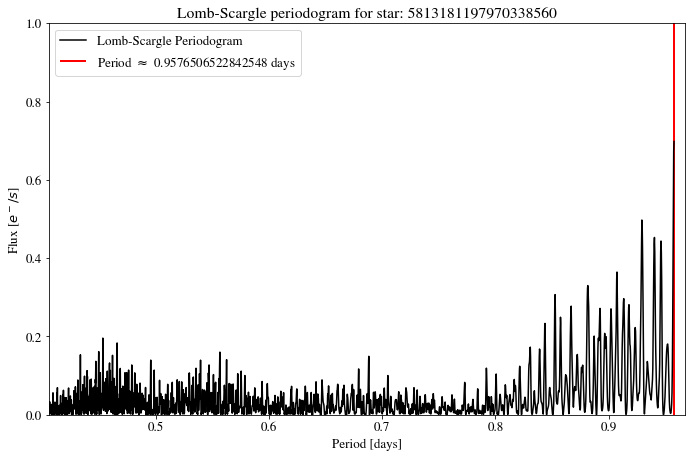

In [17]:
# graphing the lomb-scargle data so that we can analyze the data

LS_period = display_period[np.argmax(display_flux)]

fig, ax = plt.subplots()

ax.plot(display_period, display_flux, color='k', label='Lomb-Scargle Periodogram')
ax.vlines(LS_period, ymin=0, ymax=1, color='r', linewidth=2.0, zorder=2, label=f'Period $\\approx$ {LS_period} days')

ax.set_xlim(np.min(display_period), 1.01*np.max(display_period))
ax.set_xlabel('Period [days]')

ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Flux [$e^-/s$]')

ax.set_title(f'Lomb-Scargle periodogram for star: {s_id}')

ax.legend(loc='upper left')

# Phase folding

After having obtained the period, we have then taken the time array and 'folded' the values to create an array of phase values which correspond to magnitude points. We can see a legible curve which clearly has a period and some oscillatory motion in magnitude which we expect for RR Lyrae stars.

Text(0.5, 1.0, 'Phase-folded light curve for star: 5813181197970338560')

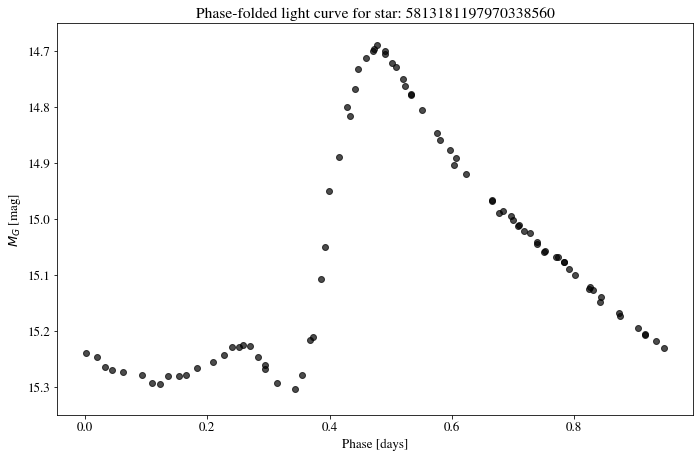

In [18]:
# creating a list of lists in which each sublist contains phases for each star

phase_tot = create_phase(periodata, period)

fig, ax = plt.subplots()

ax.scatter(phase_tot[6], mag_g, color='k', alpha=0.7)

ax.set_xlabel('Phase [days]')

ax.set_ylim(15.35, 14.65)
ax.set_ylabel('$M_G$ [mag]')

ax.set_title(f'Phase-folded light curve for star: {s_id}')

In [19]:
# for loop to obtain the average magnitude for each star

avg_mag = []

for i in range(len(periodata['mag_g'])):

    avg_mag.append(periodata['mag_g'][i][0] + 2.5*np.log(np.mean(periodata['flux_g'][i])/periodata['flux_g'][i][0]))

In [20]:
period = np.array(period)

Text(0.5, 1.0, 'Residuals between GDR2 periods and calculated periods')

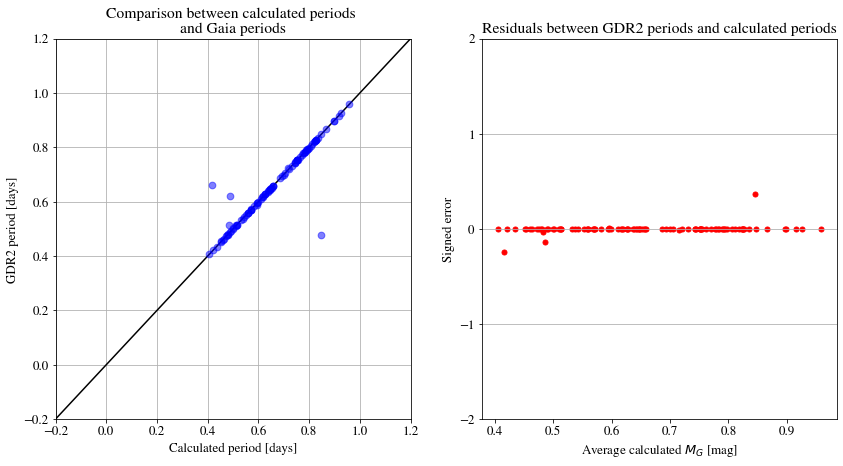

In [21]:
# plots which allow us to compare our calculated periods with gaia periods to determine accuracy

fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [2,2]}, figsize=(14.0, 7.0))

axes[0].scatter(period, rr_lyrae_data['pf'], color='b', alpha=0.5, s=45.0, zorder=20)
axes[0].plot(np.linspace(-2, 2, 2), np.linspace(-2, 2, 2), color='k')
axes[0].grid(b=True, which='major')
axes[0].set_xlim(-0.2, 1.2)
axes[0].set_ylim(-0.2, 1.2)

axes[0].set_xlabel('Calculated period [days]')
axes[0].set_ylabel('GDR2 period [days]')
axes[0].set_title('Comparison between calculated periods \nand Gaia periods')

axes[1].scatter(period, period-rr_lyrae_data['pf'], color='r', s=25.0)
axes[1].grid(b=True, axis='y')
axes[1].set_yticks(np.linspace(-2, 2, 5))
axes[1].set_xlabel('Average calculated $M_G$ [mag]')
axes[1].set_ylabel('Signed error')
axes[1].set_title('Residuals between GDR2 periods and calculated periods')

Most of the errors are within $10^{-5}$ orders of magnitude which indicates that our predicted periods are very accurate compared to the ones given by Gaia. This in turn gives us more accurate determinations for our Fourier series fitting since we reduce the problem of fitting curves to the light curves from a nonlinear optimization problem to a linear optimization by knowing what the angular frequency $\omega$ is. This will also allow us to more accurately determine a period-magnitude relation which is our primary objective.

Suppose we have a function $f: \mathbb{R} \rightarrow \mathbb{R}$ which is a time dependent function that takes time as input and outputs some sort of magnitude. If this function is sufficiently smooth, that is, if it is an element the function space $C^1$, then we can decompose it into a sum of sines and cosines.

This gives us:
$$
f(t) \approx \sum_{n=0}^{N} \left[a_n\cos{(n\omega t)} + b_n\sin{(n\omega t)}\right] = a_0 + \sum_{n=1}^{N} \left[a_n\cos{(n \omega t)} + b_n\sin{(n \omega t)}\right].
$$
In the limit $N \rightarrow \infty$, the approximation becomes an equals.

Now, if we know what $\omega$ is, then we can treat this as a linear algebra problem $\textbf{y} = \textbf{A}\mathbf{\beta}$ where $\textbf{y}$ is a vector of our fluxes,

$$
\textbf{A} =
\begin{pmatrix}
1 & \cos{(\omega t_0)} & \cdots & \cos{[(N-1) \omega t_0]} & \cos{(N \omega t_0)} & \sin{(\omega t_0)} & \cdots & \sin{[(N-1) \omega t_0]} & \sin{(N \omega t_0)} \\
1 & \cos{(\omega t_1)} & \cdots & \cos{[(N-1) \omega t_1]} & \cos{(N \omega t_1)} & \sin{(\omega t_1)} & \cdots & \sin{[(N-1) \omega t_1]} & \sin{(N \omega t_1)} \\
\vdots & \vdots & & & \ddots & & & & \vdots \\
1 & \cos{(\omega t_n)} & \cdots & \cos{[(N-1) \omega t_n]} & \cos{(N \omega t_n)} & \sin{(\omega t_n)} & \cdots & \sin{[(N-1) \omega t_n]} & \sin{(N \omega t_n)} \\
\end{pmatrix},
$$
and
$$
\mathbf{\beta}=
\begin{pmatrix}
a_0 \\
a_1 \\
\vdots \\
a_N \\
b_1 \\
\vdots \\
b_N \\
\end{pmatrix}.
$$
We can multiply both sides of our equation by $A^T$ which will give us a square matrix $A^TA$. Then, by multiplying both sides by the inverse of this matrix, we get

$$
\beta = (A^TA)^{-1}A^Ty
$$

which will allow us to calculate values for $\{a_n\}_{0 \leq i \leq n}$ and $\{b_n\}_{0 \leq i \leq n}$. When we alter the parameters so as to minimize the residuals, this method is known as the least squares method. Below, we will utilize scipy.optimize.curve_fit since this method employs a linear least squares method like we have derived above.

# Fourier Approximations

Now that we understand the concept of how to approximate our light curves using a Fourier series, we can carry out this approximation using scipy.optimize.curve_fit which uses a least squares algorithm to fit a model to the data present. We use our own algorithm listed above to create a Fourier series representation which then is fed into the curve_fit algorithm. We can see that after K=5, our approximation is extremely accurate to the data as the sum of the residuals vanishes.

In [22]:
# creating and initializing values to use in our curve_fit process

prd = period[6]

mag_arr = np.array([x for y,x in sorted(zip(phase_tot[6],periodata['mag_g'][6]))])
phase_copy = np.array(sorted(phase_tot[6]))
fine_grid = (np.linspace(0, prd, 600))

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


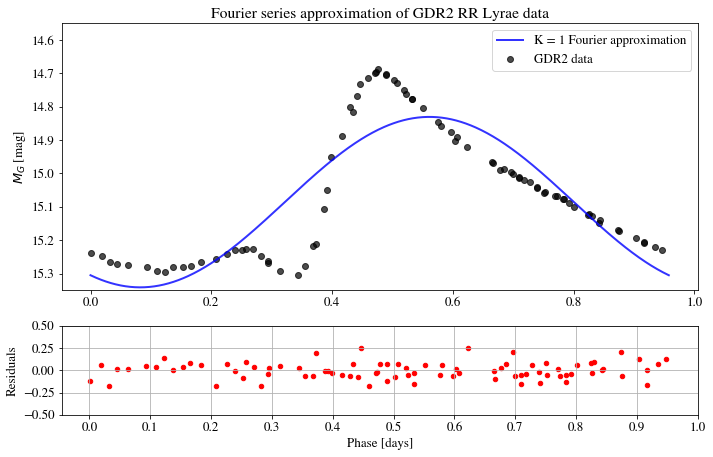

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


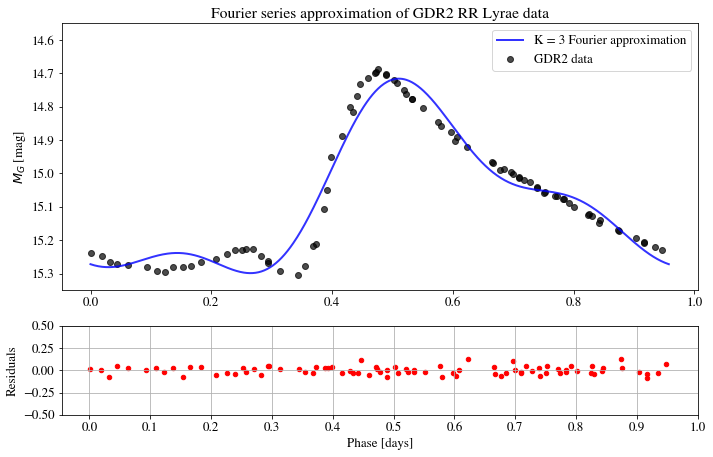

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


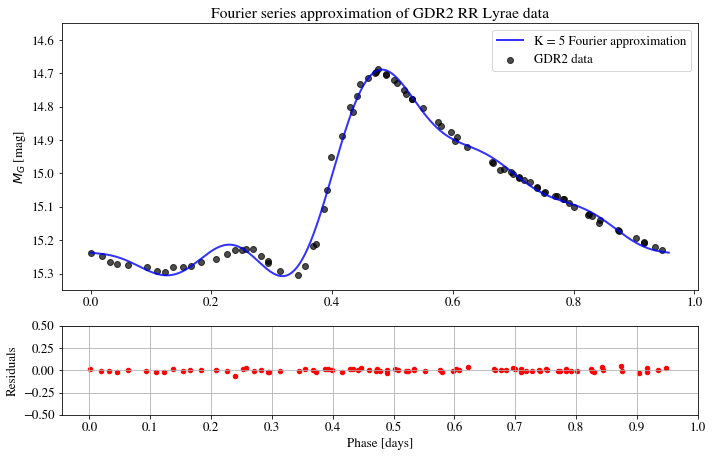

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


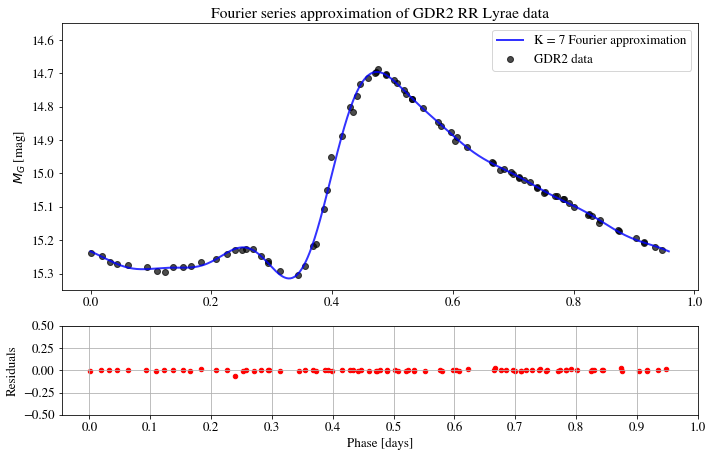

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


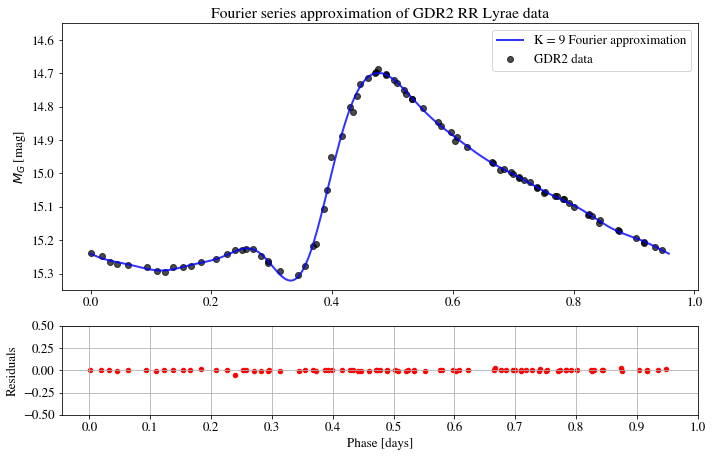

In [23]:
# for loop which creates a fourier series approximation based upon number of desired terms

for K in range(1, 10, 2):
    
    # the actual curve fit and arrays which we will use to graph
    
    popt, pcov = curve_fit(make_fourier(K), phase_copy, mag_arr, [0.0]*(2*K+2), method='lm')
    model = make_fourier(K)(phase_copy, *popt)
    fine_model = make_fourier(K)(fine_grid, *popt)
    
    residuals = mag_arr-model

    fig, axes = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [3, 1]})

    axes[0].scatter(phase_tot[6], periodata['mag_g'][6], color='k', alpha=0.7, label='GDR2 data')
    axes[0].plot(fine_grid, fine_model, color='b', alpha=0.8, linewidth=2.0, label=f'K = {K} Fourier approximation')
    axes[0].set_ylim(15.35, 14.55)
    axes[0].set_ylabel('$M_G$ [mag]')
    
    axes[1].scatter(phase_tot[6], residuals, color='r', s=20.0)
    axes[1].grid(b=True, which='major')
        
    axes[1].set_xticks(np.linspace(0, 1.0, 11))
    axes[1].set_xlabel('Phase [days]')
    
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].set_yticks(np.linspace(-0.5, 0.5, 5))
    axes[1].set_ylabel('Residuals')
    
    axes[0].set_title('Fourier series approximation of GDR2 RR Lyrae data')
    axes[0].legend()
    plt.show()

# Cross-Validation

In creating our Fourier models, we want to make sure that we are not overfitting our data so that our models can still predict the data accurately into the future. As a result, we must use cross-validation which takes a portion of our data set and uses it to train our model. Then, we can test our model on the remaining data, known as the cross-validation data, to see how accurate our model still is. We determine this accuracy by measuring the $chi^2/N_{data}$. We can see that the $chi^2/N_{data}$ for both the training data set and the cross-validation data set vanish as the value of $K$ increases.

In [24]:
# creating and initializing arrays which we need for cross-validation

k = 0.8*len(phase_copy)

random_indices = random.sample(range(0, len(phase_copy)), int(k))
other_indices = np.linspace(0, (len(phase_copy)-1), len(phase_copy))

for ind in random_indices:
    
    other_indices = np.delete(other_indices, np.where(other_indices == ind))

In [25]:
# using the arrays that we created before to create new arrays which we can then use to get chi^2

random_phase = []
random_mag = []

# for loop which goes over the indices and creates arrays for us to use

for ind in random_indices:
    
    random_phase.append(phase_copy[ind])
    random_mag.append(mag_arr[ind])
    
random_phase = random_phase
random_mag = np.array([x for y,x in sorted(zip(phase_tot[6][:68],random_mag))])
random_phase = np.array(sorted(random_phase))

N_data_cross_val = 85-len(random_mag)
N_data_train = 85-N_data_cross_val

In [26]:
residuals_arr = []
chi2_arr_train = []
chi2_arr_cross_val = []

for K in range(1, 26):
    
    popt, pcov = curve_fit(make_fourier(K), phase_copy, mag_arr, [1.0]*(2*(K+1)))
    model = make_fourier(K)(phase_copy, *popt)
    residuals = mag_arr - model
    residuals_arr.append(residuals)

for i in range(25):
    
    chi2 = 0
    
    for ind in random_indices:
        
        chi2 = chi2 + residuals_arr[i][ind]**2/mag_arr[ind]
        
    chi2_arr_train.append(chi2/N_data_cross_val)
    chi2 = 0
        
    for val in other_indices:
        
        chi2 = chi2 + residuals_arr[i][int(val)]**2/mag_arr[int(val)]
        
    chi2_arr_cross_val.append(chi2/N_data_train)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


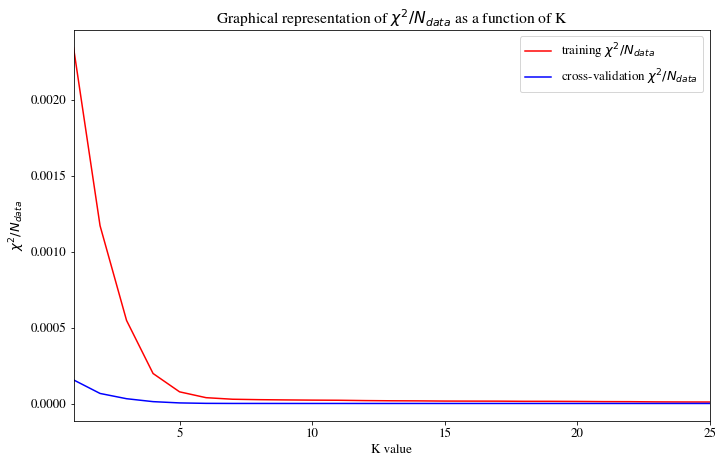

In [27]:
fig, ax = plt.subplots()

ax.plot(np.linspace(1, 25, 25), chi2_arr_train, color='r', label="training $\chi^2/N_{data}$")
ax.plot(np.linspace(1, 25, 25), chi2_arr_cross_val, color='b', label="cross-validation $\chi^2/N_{data}$")

ax.set_xlim(1, 25)
ax.set_xlabel("K value")

ax.set_ylabel("$\chi^2/N_{data}$")

ax.set_title("Graphical representation of $\chi^2/N_{data}$ as a function of K")

ax.legend()

We see that for our training dataset that the value for $\chi^2/N$ decreases with increasing $K$ values, but for our cross validation dataset the value of $\chi^2/N$ is roughly the same. We can see, however, that for a value of $K=7$ that the $\chi^2/N$ value is much smaller than 1 and approaching zero quickly and therefore there is negligible difference between $K=7$ models and higher $K$ models. Hence, we see that $K=7$ is an appropriate value for later models.

# Extrapolating into the future

As we said before, we would like to extrapolate our models into the future to accurately determine the unfolding of phenomena in time. Since RR Lyrae exhibiting only a fundamental pulsation mode frequency or a frequency that is much larger than other frequencies are relatively stable, this prediction is rather simple and we can see that the curve we predicted before repeats itself continuously with no shift in the amplitude or periodicity over the next 10 days.

In [28]:
delta_time = 2329.0 - time_g[-1]
phase = delta_time % prd
popt, pcov = curve_fit(make_fourier(7), phase_copy, mag_arr, [1.0]*(2*7+2))
model = make_fourier(7)(fine_grid, *popt)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [29]:
extended_model = 11*model.tolist()

Text(0.5, 1.0, 'Extrapolated light curve from the final GDR2 data points using K = 7 Fourier model')

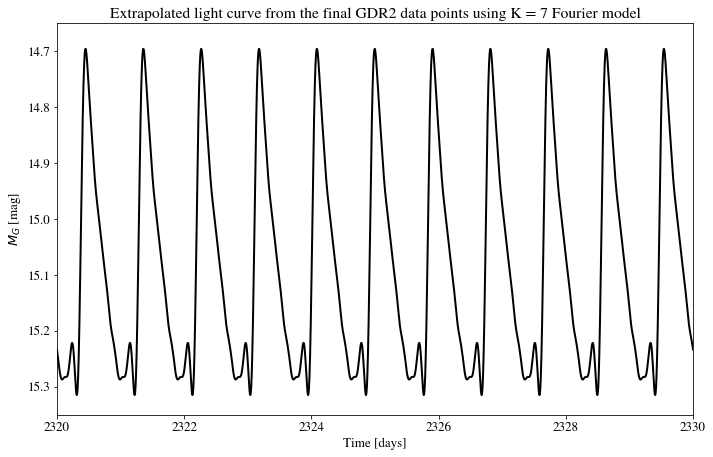

In [30]:
fig, ax = plt.subplots()

ax.plot(np.linspace(2320, 2330, len(extended_model)), extended_model, color='k', linewidth=2.0)

ax.set_xlim(2320, 2330)
ax.set_xlabel('Time [days]')

ax.set_ylim(15.35, 14.65)
ax.set_ylabel('$M_G$ [mag]')

ax.set_title('Extrapolated light curve from the final GDR2 data points using K = 7 Fourier model')

# Gaia DR2 magnitudes vs. Our calculated magnitudes

As we said in the beginning, we want to determine how accurate our calculated magnitudes are compared to the ones given to us by Gaia because we would like to use Gaia's magnitudes to determine a period-luminosity relationship. To determine this relationship, we need both accurate periods and magnitudes. We can see below that our magnitudes follow a roughly linear relationship with the ones given to us by Gaia with some divergences from the linear relationship. However, there are no outliers which indicates to us that our magnitudes are within a certain level of precision compared to the Gaia magnitudes, as also evinced by the residuals graph to the right of the linear relation graph. Moreover, we perform an analysis below to determine what percentage of our calculated magnitudes are within $5\%$ and $2\%$ of the magnitudes given by Gaia.

In [31]:
avg_mag_g_tot = []

for i in range(len(periodata['flux_g'])):
    
    prd = period[i]
    popt, pcov = curve_fit(make_fourier(7), phase_tot[i], periodata['flux_g'][i], [1.0]*(2*7+2))
    fine_model = make_fourier(7)(fine_grid, *popt)
    mean_flux = np.mean(fine_model)
    avg_mag = 25.7 -2.5*np.log10(mean_flux)
    
    avg_mag_g_tot.append(avg_mag)
    
residuals = rr_lyrae_data['int_average_g'] - np.array(avg_mag_g_tot)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, 'Residuals between GDR2 data \nand calculated magnitudes')

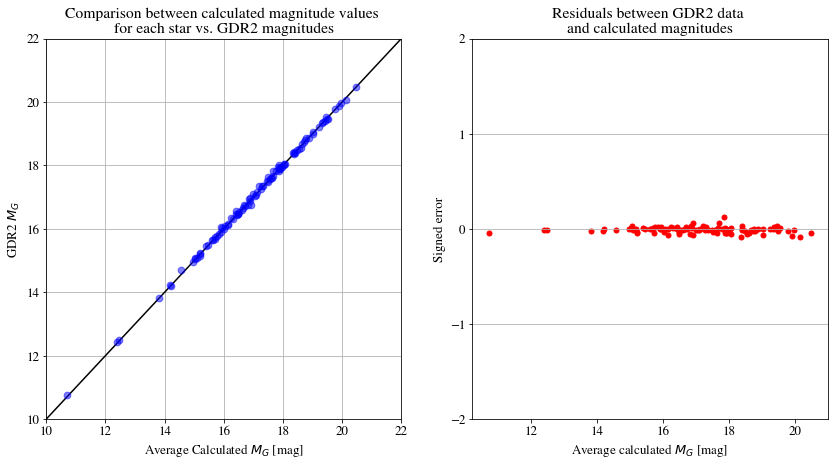

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [2,2]}, figsize=(14.0, 7.0))

axes[0].scatter(avg_mag_g_tot, rr_lyrae_data['phot_g_mean_mag'], color='b', alpha=0.5, s=45.0, zorder=20)
axes[0].plot(np.linspace(10, 22, 2), np.linspace(10, 22, 2), color='k')
axes[0].grid(b=True, which='major')
axes[0].set_xlim(10, 22)
axes[0].set_ylim(10, 22)

axes[0].set_xlabel('Average Calculated $M_G$ [mag]')
axes[0].set_ylabel('GDR2 $M_G$')
axes[0].set_title('Comparison between calculated magnitude values \nfor each star vs. GDR2 magnitudes')

axes[1].scatter(avg_mag_g_tot, residuals, color='r', s=25.0)
axes[1].grid(b=True, axis='y')
axes[1].set_yticks(np.linspace(-2, 2, 5))
axes[1].set_xlabel('Average calculated $M_G$ [mag]')
axes[1].set_ylabel('Signed error')
axes[1].set_title('Residuals between GDR2 data \nand calculated magnitudes')

In [33]:
pos = []
neg = []
small_err = 0
smaller_err = 0

for res, gdr2_mag in zip(residuals, rr_lyrae_data['phot_g_mean_mag']):
    
    rel_err = res/gdr2_mag
    
    if rel_err < 0:
        
        neg.append(rel_err)
        
    else:
        
        pos.append(rel_err)
        
    if abs(rel_err)*100 < 5:
        
        small_err+=1
        
        if abs(rel_err)*100 < 2:
            
            smaller_err+=1
        
print(f'The amount of positive residuals is {len(pos)} \n')
print(f'The amount of negative residuals is {len(neg)} \n')
print(f'The amount of errors less than 5 percent is {small_err} out of {len(residuals)} \n')
print(f'The amount of errors less than 1 percent is {smaller_err} out of {len(residuals)}')

The amount of positive residuals is 34 

The amount of negative residuals is 66 

The amount of errors less than 5 percent is 100 out of 100 

The amount of errors less than 1 percent is 100 out of 100


We can see that our calculated magnitudes are exceptionally accurate when compared to the Gaia magnitudes as all calculated magnitudes are less than $1\%$ different from the Gaia values.

# RRab and RRc variables

Now, we would like to extend our analysis to RRab and RRc variables as well as the initial 100 we queried initially. We do this to determine the attributes of these stars such as their periodicity, magnitudes, etc. 

In [34]:
rr_lyrae_data2 = gaia_query("SELECT TOP 3 * FROM gaiadr2.gaia_source JOIN gaiadr2.vari_rrlyrae USING (source_id) \
WHERE best_classification = 'RRc' \
AND int_average_g < 15 \
AND num_clean_epochs_g > 80;")

In [35]:
organized_RRc = organize_data(rr_lyrae_data2)

In [36]:
periodata_RRc = periodogram_data(organized_RRc)

In [37]:
f_max_RRc = 1/np.max(rr_lyrae_data2['p1_o'])
f_min_RRc = 1/np.min(rr_lyrae_data2['p1_o'])
length_RRc = len(periodata_RRc['time_g'])
period_arr_RRc = []

for i in range(length_RRc):

    flux_g = np.array(periodata_RRc['flux_g'][i])
    flux_err_g = np.array(periodata_RRc['flux_err_g'][i])
    mean_flux = np.mean(flux_g)
    mag_g = periodata_RRc['mag_g'][i][0] -2.5*np.log10(flux_g/periodata_RRc['flux_g'][i][0])
    mag_err_g = np.abs(-2.5*flux_err_g/(2.3*flux_g))
    time_g = np.array(periodata_RRc['time_g'][i])
    freq, flux = LombScargle(periodata_RRc['time_g'][i], periodata_RRc['flux_g'][i],
                             periodata_RRc['flux_err_g'][i]).autopower(nyquist_factor=100,
                                                                minimum_frequency=f_max_RRc, maximum_frequency=f_min_RRc)
    
    
    period_arr_RRc.append(1/freq[np.argmax(flux)])
    
period_RRc = np.array(period_arr_RRc)

In [38]:
phase_tot_RRc = create_phase(periodata_RRc, rr_lyrae_data2['p1_o'])

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


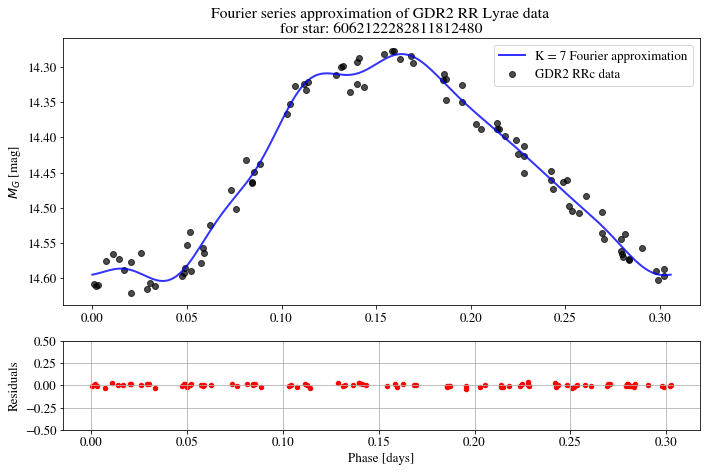

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


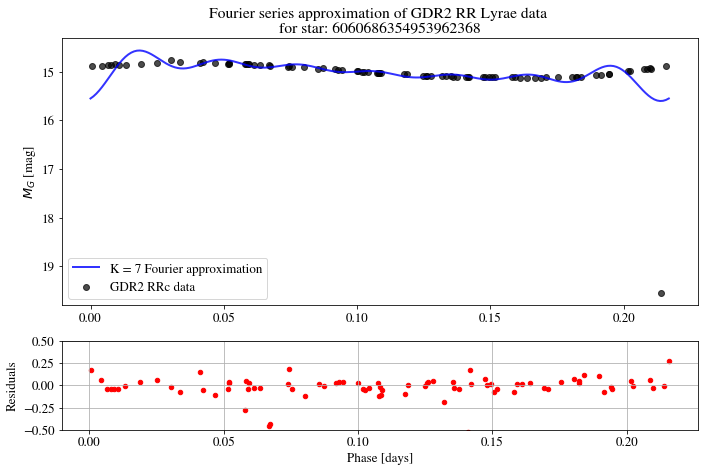

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


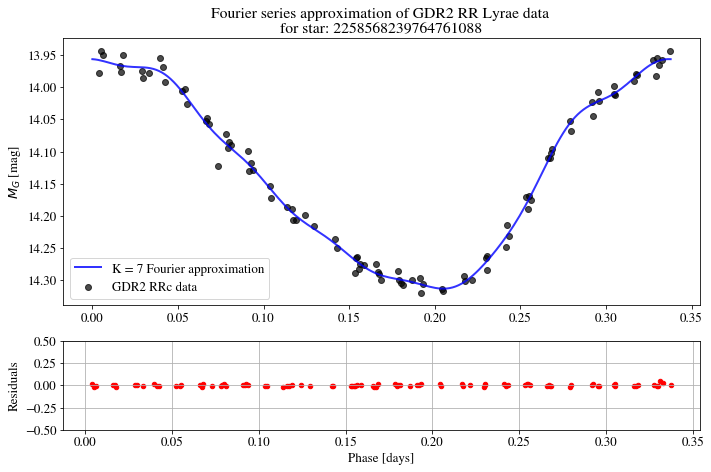

In [39]:
models_arr = []
fine_grids_arr = []
source_ids = []

K = 7

for i in range(length_RRc):

    prd = period_RRc[i]
    mag_arr = np.array([x for y,x in sorted(zip(phase_tot_RRc[i],periodata_RRc['mag_g'][i]))])
    phase_copy = np.array(sorted(phase_tot_RRc[i]))
    fine_grid = (np.linspace(0, period_RRc[i], 200))
    fine_grids_arr.append(fine_grid)
    
    popt, pcov = curve_fit(make_fourier(7), phase_copy, mag_arr, [1.0]*(2*7+2))
    model = make_fourier(7)(phase_copy, *popt)
    fine_model = make_fourier(7)(fine_grid, *popt)
    models_arr.append(fine_model)
    
    source_id = organized_RRc[i]['source_id']
    source_ids.append(str(source_id))
    
    residuals = mag_arr-model

    fig, axes = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [3, 1]})

    axes[0].scatter(phase_tot_RRc[i], periodata_RRc['mag_g'][i], color='k', alpha=0.7, label='GDR2 RRc data')
    axes[0].plot(fine_grid, fine_model, color='b', alpha=0.8, linewidth=2.0, label=f'K = {K} Fourier approximation')
    #axes[0].set_ylim(15.35, 14.55)
    axes[0].set_ylabel('$M_G$ [mag]')
    axes[0].invert_yaxis()
    
    axes[1].scatter(phase_tot_RRc[i], residuals, color='r', s=20.0)
    axes[1].grid(b=True, which='major')
        
    axes[1].set_xlabel('Phase [days]')
    
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].set_yticks(np.linspace(-0.5, 0.5, 5))
    axes[1].set_ylabel('Residuals')
    
    axes[0].set_title(f'Fourier series approximation of GDR2 RR Lyrae data \nfor star: {source_id}')
    axes[0].legend()
    plt.show()

In [40]:
rr_lyrae_data3 = gaia_query("SELECT TOP 3 * FROM gaiadr2.gaia_source JOIN gaiadr2.vari_rrlyrae USING (source_id) \
WHERE best_classification = 'RRab' \
AND phot_g_mean_mag < 15 \
AND num_clean_epochs_g > 80;")

In [41]:
organized_RRab = organize_data(rr_lyrae_data3)

In [42]:
periodata_RRab = periodogram_data(organized_RRab)

In [43]:
f_max_RRab = 1/np.min(rr_lyrae_data3['pf'])
f_min_RRab = 1/np.max(rr_lyrae_data3['pf'])
length_RRab = len(periodata_RRab['time_g'])
period_arr_RRab = []

for i in range(length_RRab):

    flux_g = np.array(periodata_RRab['flux_g'][i])
    flux_err_g = np.array(periodata_RRab['flux_err_g'][i])
    mean_flux = np.mean(flux_g)
    mag_g = periodata_RRab['mag_g'][i][0] -2.5*np.log10(flux_g/periodata_RRab['flux_g'][i][0])
    mag_err_g = np.abs(-2.5*flux_err_g/(2.3*flux_g))
    time_g = np.array(periodata_RRab['time_g'][i])
    freq, flux = LombScargle(periodata_RRab['time_g'][i], periodata_RRab['flux_g'][i],
                             periodata_RRab['flux_err_g'][i]).autopower(samples_per_peak=100,
                                                                        nyquist_factor=100,
                                                                        maximum_frequency=f_max_RRab,
                                                                        minimum_frequency=f_min_RRab)
    
    
    period_arr_RRab.append(1/freq[np.argmax(flux)])
    
period_RRab = np.array(period_arr_RRab)

In [44]:
phase_tot_RRab = create_phase(periodata_RRab, period_RRab)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


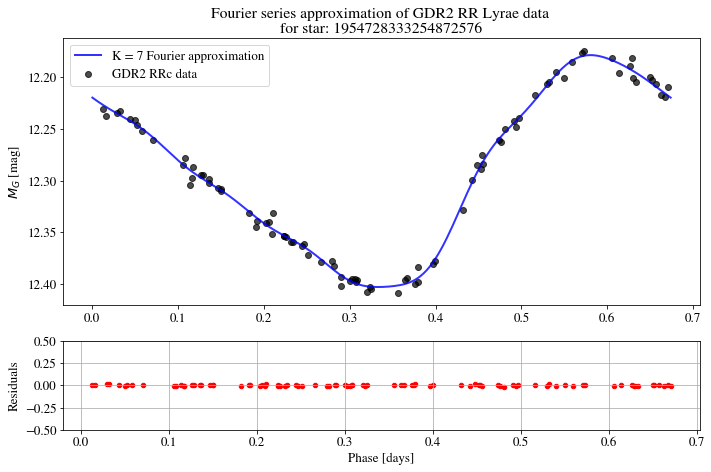

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


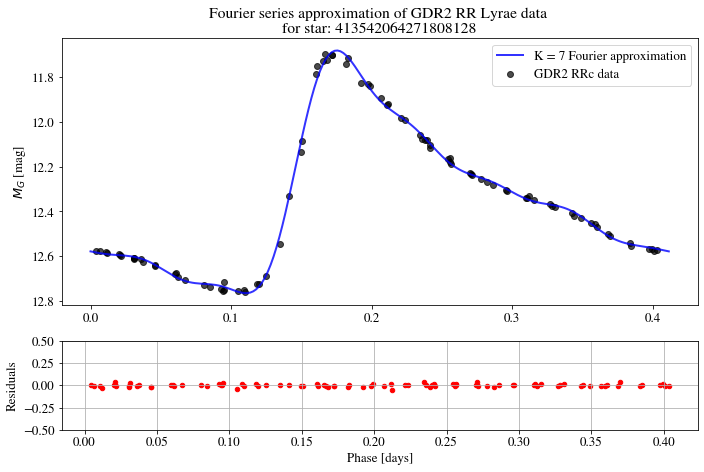

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


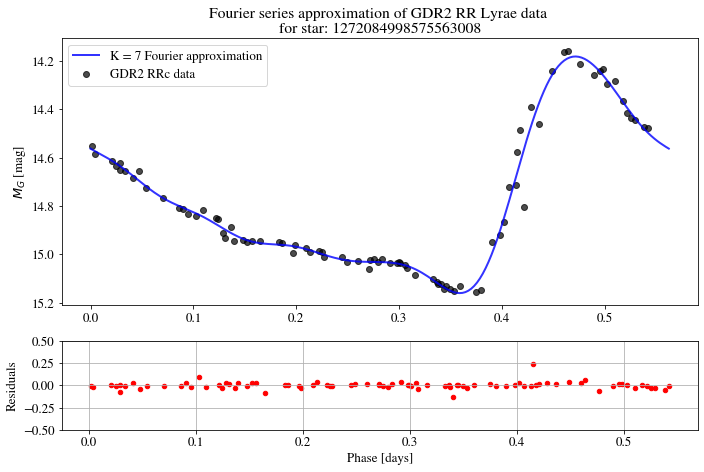

In [45]:
for i in range(length_RRab):

    prd = period_RRab[i]
    mag_arr = np.array([x for y,x in sorted(zip(phase_tot_RRab[i],periodata_RRab['mag_g'][i]))])
    phase_copy = np.array(sorted(phase_tot_RRab[i]))
    fine_grid = (np.linspace(0, period_RRab[i], 200))
    fine_grids_arr.append(fine_grid)
    
    popt, pcov = curve_fit(make_fourier(7), phase_copy, mag_arr, [1.0]*(2*7+2))
    model = make_fourier(7)(phase_copy, *popt)
    fine_model = make_fourier(7)(fine_grid, *popt)
    models_arr.append(fine_model)
    
    source_id = organized_RRab[i]['source_id']
    source_ids.append(str(source_id))
    
    residuals = mag_arr-model
    
    fig, axes = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [3, 1]})

    axes[0].scatter(phase_tot_RRab[i], periodata_RRab['mag_g'][i], color='k', alpha=0.7, label='GDR2 RRc data')
    axes[0].plot(fine_grid, fine_model, color='b', alpha=0.8, linewidth=2.0, label=f'K = {K} Fourier approximation')
    axes[0].set_ylabel('$M_G$ [mag]')
    axes[0].invert_yaxis()
    
    axes[1].scatter(phase_tot_RRab[i], residuals, color='r', s=20.0)
    axes[1].grid(b=True, which='major')
        
    axes[1].set_xlabel('Phase [days]')
    
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].set_yticks(np.linspace(-0.5, 0.5, 5))
    axes[1].set_ylabel('Residuals')
    
    axes[0].set_title(f'Fourier series approximation of GDR2 RR Lyrae data \nfor star: {source_id}')
    axes[0].legend()
    plt.show()

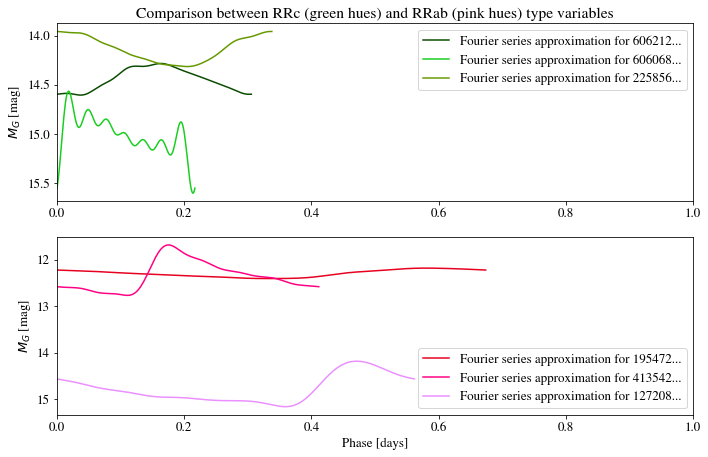

In [46]:
fig, axes = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 1]})
colors = ['#094B00',
          '#19CE20',
          '#669900',
          '#e7001f',
          '#ff0083',
          '#ea90ff']

i=1
for grid, model, color, sid in zip(fine_grids_arr, models_arr, colors, source_ids):
    
    if i < 4:
        
        axes[0].plot(grid, model, color=color, label=f'Fourier series approximation for {sid[:6]}...')
        
    else:
        
        axes[1].plot(grid, model, color=color, label=f'Fourier series approximation for {sid[:6]}...')
        
    i+=1
    
axes[0].legend()
axes[1].legend()
axes[0].set_xlim(0.0, 1.0)
axes[1].set_xlim(0.0, 1.0)

axes[1].set_xlabel('Phase [days]')

axes[0].set_ylabel('$M_G$ [mag]')
axes[1].set_ylabel('$M_G$ [mag]')

axes[0].set_title('Comparison between RRc (green hues) and RRab (pink hues) type variables')
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# RRc versus RRab type variable comparison

We can see that RRc type variables have much shorter periods and go through their oscillations multiple times within 1 day while RRab type variables have longer periods and may only go through one oscillation per day. Additionally, we see that RRab stars also have greater ranges of magnitudes over one oscillation. Moreover, these changes tend to happen over a much shorter time period relative to the RRc type variables which have more steady sinusoidal oscillatory behavior. Finally, RRc variables are much less likely to exhibit the Blazhko effect compared to RRab variables. As a result, RRab variables have more variable light curves over time compared to RRc variables which have more consistent light curves over time due to period modulation as evinced in observations.

# Simple Periodicity?

For our RRc stars, there aappears to be one star, star 606068... which does have some type of internal scatter meaning that it could potentially be exhibiting the Blazhko effect. However, this could also be due to our model fit or Gaia's data. The other RRc stars exhibit a clearly defined period and do not vary much over that period. On the other hand, the RRab stars appear to vary greater amounts and their change in magnitude is much greater than the RRc stars. However, we so that none of them correspond to any period outside of their fundamental pulsation mode period. Though, star 195472... does have an oddly shaped light curve that does not truly exhibit much change in the magnitude. However, this could also be due to our y-scale being too large to see the variation on this graph.

# The impact of dust on distance measurements

If there does exist dust between us and the observed RR Lyrae variables, then we will not see the magnitude properly. The reasoning is as follows: when the photons emitted from the variables reach the dust, the shorter wavelength photons scatter off of the dust and as a result change direction and do not reach our observation equipment such as our telescopes. As a result of these shorter wavelength photons not reaching our telescopes, we perceive the color emitted to be much redder than it actually is. We could then improperly deduce that the wavelengths of these variables is redshifted thus making us believe that they are much further away from us than they actually are. Hence, we need as little dust between us and the variables to make accurate measurements of their distances.

In [47]:
rr_lyrae_data4 = gaia_query("SELECT * FROM gaiaedr3.gaia_source JOIN gaiadr2.vari_rrlyrae USING (source_id) \
WHERE parallax_over_error > 5 \
AND pf != 0 \
AND abs(parallax) > 0.25 \
AND abs(b) > 30 \
ORDER BY source_id ASC;")

print(len(rr_lyrae_data4))

484


We see that there are approximately 500 stars that satisfy the criteria needed to determine a period-luminosity relationship. In this query, we joined using the source identifier tag. We can actually increase the number of stars that satisfy this criteria by being more specific with our join criteria which we do so in the next two queries.

In [48]:
rr_lyrae_data5 = gaia_query("SELECT * FROM gaiaedr3.dr2_neighbourhood as edr3 \
JOIN gaiadr2.vari_rrlyrae as rrlyr_dr2 ON edr3.dr2_source_id = rrlyr_dr2.source_id \
JOIN gaiadr2.gaia_source as dr2 ON edr3.dr2_source_id = dr2.source_id \
JOIN gaiaedr3.gaia_source as edr32 ON edr3.dr3_source_id = edr32.source_id \
WHERE rrlyr_dr2.pf != 0 \
AND abs(edr32.parallax) > 0.25 \
AND edr32.parallax_over_error > 5 \
AND ABS(edr32.b) > 30;")

print(len(rr_lyrae_data5))

548


# Why would source id's change?

We can see that 64 source identifiers have changed from the GDR2 release to the EDR3 release. The way that the Gaia DR3 source list is composed is as follows: the observations of the sky made from 2014 up to 2017 are taken and processed so that the sky can be partitioned. This partitioning is done by associating physical objects in the sky to observed physical light sources so that clusters are formed. These clusters are created by this partition so that they are disjoint and do not overlap. These clusters have associated astrometric and photometric data. These new clusters are not generated using the old Gaia catalogue and so they can be cross matched with the old Gaia catalogue. The stars that were matched with a source identifier previously are checked to see if their parameters match with the updated parameters of the same identifier in the new catalogue. If they do match, then they retain their source identifier. If not, they are checked with other possible clusters and so may change source identifiers.

In [49]:
dist_data = gaia_query("SELECT * FROM external.gaiaedr3_distance as dist \
JOIN gaiaedr3.gaia_source as edr3 ON dist.source_id = edr3.source_id \
JOIN gaiaedr3.dr2_neighbourhood as nbor ON edr3.source_id = nbor.dr3_source_id \
JOIN gaiadr2.gaia_source as dr2 ON dr2.source_id = nbor.dr2_source_id \
JOIN gaiadr2.vari_rrlyrae as vari ON vari.source_id = nbor.dr2_source_id \
WHERE edr3.parallax_over_error > 5 \
AND edr3.parallax > 0.25 \
AND abs(edr3.b) > 30 \
AND vari.pf != 0 \
ORDER BY edr3.source_id ASC;")

# Bailer-Jones catalogue

We see from [Bailer-Jones 2020](https://arxiv.org/pdf/2012.05220.pdf) and [Bailer-Jones 2015](https://iopscience.iop.org/article/10.1086/683116/pdf) that r_med_geo, r_lo_geo, and r_hi_geo are calculated first by choosing a prior for the parallax which is a Gaussian distribution and then using Bayes' Theorem to obtain a posterior for $r$, the distance, by multiplying the prior times the probability of $r$. If

$$
P(\varpi| r, \sigma_{\varpi})
$$

is the Gaussian prior, then

$$
P(r| \varpi, \sigma_{\varpi}) = P(\varpi| r, \sigma_{\varpi})P(r)
$$

is the posterior distribution of $r$. From here, the distance corresponding to the mode of the posterior is r_med_geo, the point corresponding to the 16th percentile is r_lo_geo, and the point corresponding to the 84th percentile is r_hi_geo.


These distances are important because they take into account the fact that $1/r$ is a nonlinear transformation and so a symmetric uncertainty in $\varpi$ will turn into a non-symmetric uncertainty in $r$ and can even turn into an uncertainty that renders the naive calculation $1/\varpi$ for $r$ and vice-versa completely useless. Taking this into account allows for greater confidence in claiming what the actual distances of stars are.

In [50]:
gal_long = dist_data['l']
gal_lat = dist_data['b']

Text(0.5, 1.0, 'Distribution of galactic latitude $b$')

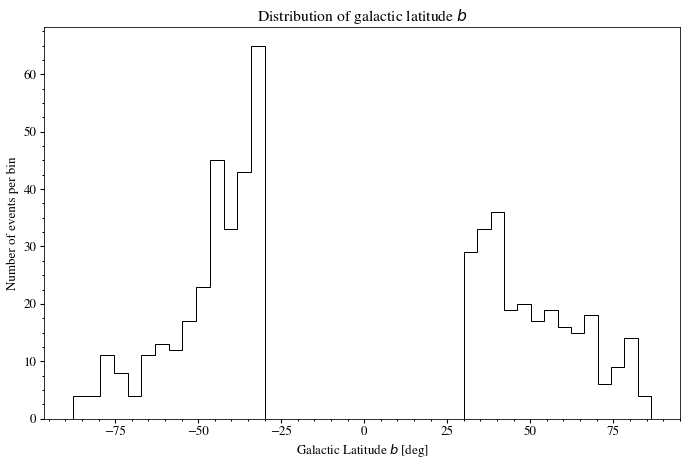

In [51]:
fig, ax = plt.subplots()

ax.hist(gal_lat, bins=np.concatenate((np.linspace(np.min(gal_lat), -30, 15), np.linspace(-30, 30, 15),
                                     np.linspace(30, np.max(gal_lat), 15)))
                       , color='k', histtype='step')

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.tick_params(which='minor', width = 1.0)
ax.tick_params(which='minor', length = 2.0)
ax.tick_params(which='major', width=1.1)
ax.tick_params(which='major', length=4.0)
ax.set_xlabel('Galactic Latitude $b$ [deg]')

ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=4))
ax.tick_params(which='minor', width = 1.0)
ax.tick_params(which='minor', length = 2.0)
ax.tick_params(which='major', width=1.1)
ax.tick_params(which='major', length=4.0)
ax.set_ylabel('Number of events per bin')

ax.set_title('Distribution of galactic latitude $b$')

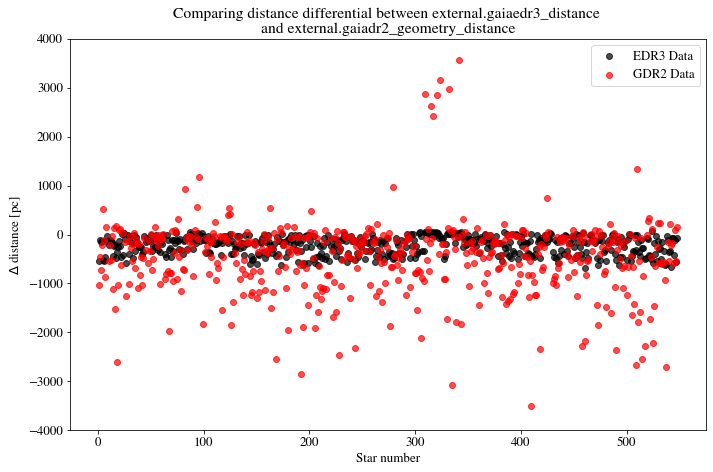

In [52]:
fig, ax = plt.subplots()

ax.scatter(np.linspace(1, 548, 548), dist_data['r_med_geo']-1000/dist_data['parallax'], color='k', alpha=0.7,
           label='EDR3 Data')
ax.scatter(np.linspace(1, 548, 548), dist_data['r_med_geo']-1000/dist_data['parallax_2'], color='r', alpha=0.7,
          label='GDR2 Data')

ax.set_xlabel('Star number')
ax.set_ylabel('$\Delta$ distance [pc]')
ax.set_title('Comparing distance differential between external.gaiaedr3_distance \nand external.gaiadr2_geometry_distance')

ax.set_ylim(-4000, 4000)

ax.legend()

# How do EDR3 and DR2 distances compare to Bailor-Jones?

We can see from the graph above that the residuals calculated using the EDR3 datat is much closer to 0 compared to the DR2 residuals. Specifically, we see that almost all of the EDR3 residuals are in the range $[-500, 0]$ with only a few outliers lying outside of that range; whereas, we see many residuals lying outside of the range $[-500, 0]$ with many more distances greater than 500pc compared to the Bailor-Jones data. The reason for this is that with the new data collected by Gaia there are updates to the parallax determinations which result in parallaxes that are closer to the Bailor-Jones calculations from the Gaia data.

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


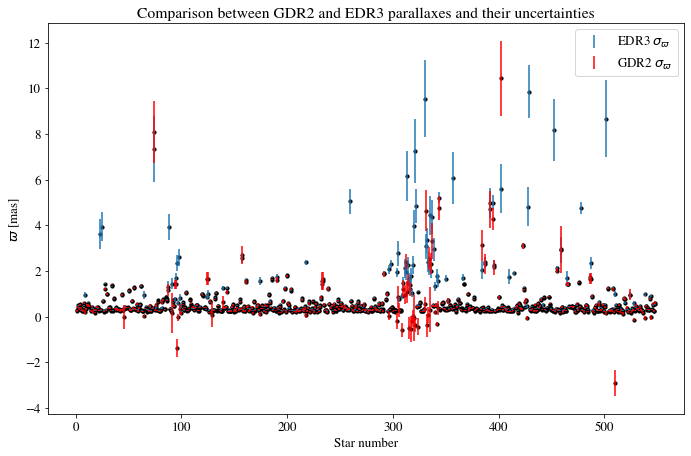

In [53]:
fig, ax = plt.subplots()

ax.scatter(np.linspace(1, 548, 548), dist_data['parallax'], color='k', s=10.0)
ax.errorbar(np.linspace(1, 548, 548), dist_data['parallax'], yerr=dist_data['parallax_error'], ls='none',
            label='EDR3 $\sigma_{\\varpi}$')
ax.scatter(np.linspace(1, 548, 548), dist_data['parallax_2'], color='k', s=10.0)
ax.errorbar(np.linspace(1, 548, 548), dist_data['parallax_2'], yerr=dist_data['parallax_error_2'], ls='none', ecolor='r',
           label='GDR2 $\sigma_{\\varpi}$')

ax.set_xlabel('Star number')
ax.set_ylabel('$\\varpi$ [mas]')
ax.set_title('Comparison between GDR2 and EDR3 parallaxes and their uncertainties')

ax.legend()

In [54]:
print(np.mean(dist_data['parallax_error_2']))
print(np.mean(dist_data['parallax_error']))

0.08172815234596577
0.08029398952957488


We can see above that the average $\sigma_{\varpi}$ for DR2 is roughly $0.08172815$ which is approximately $1.017861$ times greater than $\sigma_{\varpi}$ for EDR3 which is roughly $0.08029398$.

In [55]:
rel_err = 100*((dist_data['parallax_error_2'])-abs(dist_data['parallax_error']))/abs(dist_data['parallax_error'])

In [56]:
print(np.mean(rel_err))

78.15676101334233


We can see that the average relative error between the DR2 $\sigma_{\varpi}$ and EDR3 $\sigma_{\varpi}$ values is approximately $78.1\%$ which is a large difference. We used the formula

$$
\text{Modified Relative Error} \equiv 100 \times \frac{\sigma_{\varpi}^{DR2} - |\sigma_{\varpi}^{EDR3}|}{|\sigma_{\varpi}^{EDR3}|}
$$

to obtain the modified error. This modified error gives us the signed absolute change between the uncertainties from DR2 to EDR3. Since this average value is largely positive and we treat only the modulus of the EDR3 uncertainty, we see that the DR2 uncertainties on average must be approximately $75\%$ larger than the EDR3 values or that the EDR3 values are that percentage smaller on average compared with the DR2 uncertainty values.

# Why are the EDR3 parallax values more precise?

Astrometric Global Iterative Solutions are produced by Gaia using source image locations. These solutions are produced from observational data obtained by Gaia. These solutions use point-spread functions (PSF) or line-spread functions (LSF) which are fitted to 1D and 2D observational windows. In these windows are the source image locations. There have been enhancements to these functions which allow for more accurate determinations of astrometric parameters. Part of these enhancements is the actual refined data itself that was released in second data release. Specifically, the improved parameters allow for improvements to the PSF and LSF and so on. Furthermore, there have been improvements in the corrections for the miscalibration caused by the rotation of the telescope used; this allows for greater precision in parallax determinations. This in turn reduced the parallax zero point from $-29\mu\text{as}$ to $-17\mu\text{as}$. Finally, another calibration model was included to handle focal length and optical distortions on smaller scales than the currently implemented calibration model. This allows for refined measurements of parallax. 

In [57]:
abs_mag = dist_data['phot_g_mean_mag']+5+5*np.log10(1/dist_data['r_med_geo'])
abs_mag_2 = dist_data['phot_g_mean_mag']+5+5*np.log10(dist_data['parallax']/1000)
low_mag_err = dist_data['phot_g_mean_mag']+5+5*np.log10(1/dist_data['r_lo_geo'])
hi_mag_err = dist_data['phot_g_mean_mag']+5+5*np.log10(1/dist_data['r_hi_geo'])
sym_err = (hi_mag_err - low_mag_err)/2

Text(0.5, 1.0, 'Calculated absolute magnitude from EDR3 magnitudes and \nexternal.edr3_distance geometric distance catalogue with errors')

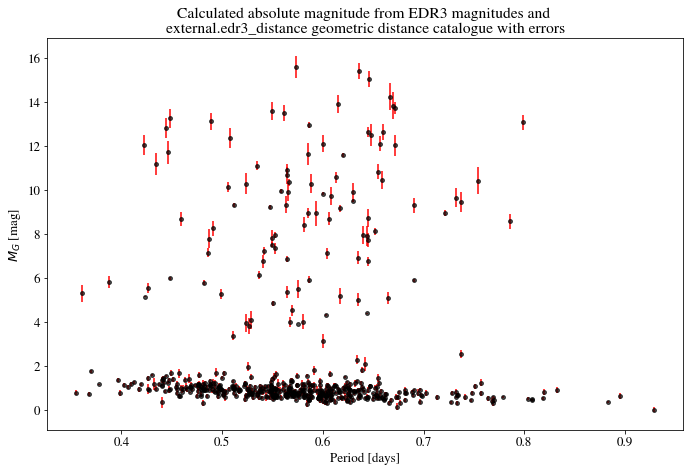

In [58]:
fig, ax = plt.subplots()

ax.scatter(dist_data['pf'], abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
ax.vlines(dist_data['pf'], ymin=abs_mag-sym_err, ymax=abs_mag+sym_err, color='r')

ax.set_xlabel('Period [days]')
ax.set_ylabel('$M_G$ [mag]')
ax.set_title('Calculated absolute magnitude from EDR3 magnitudes and \nexternal.edr3_distance geometric distance catalogue \
with errors')

In [59]:
new_abs_mag = []
new_period = []
new_sym_err = []

for i in range(len(abs_mag)):
    
    max_val=np.max([1, np.exp(-0.2*(dist_data['phot_g_mean_mag'][i]-19))])
    
    if np.sqrt(dist_data['astrometric_chi2_al'][i]/(dist_data['astrometric_n_good_obs_al'][i])) < 1.2*max_val:
        
        if 1.0+0.015*dist_data['bp_rp'][i]**2 < dist_data['phot_bp_rp_excess_factor'][i] < \
                                                   1.3+0.06*dist_data['bp_rp'][i]**2:
            
            new_abs_mag.append(abs_mag[i])
            new_period.append(dist_data['pf'][i])
            new_sym_err.append(sym_err[i])
            
new_abs_mag = np.array(new_abs_mag)
new_sym_err = np.array(new_sym_err)

After applying the cuts in [Lindegren et al. 2018](https://arxiv.org/abs/1804.09366), we remove much of the scatter while still leaving a large portion of the points clustered in the $[0, 2]$ magnitude range. This is because the photometric cuts applied above remove stars which do not have precisely measured parallax and are therefore unreliable candidates to determine a period-luminosity relation.

Text(0.5, 1.0, 'Absolute magnitude after applying Lindegren cuts')

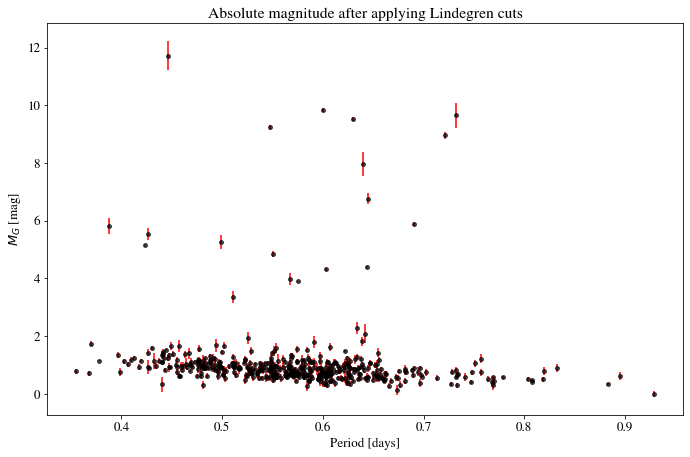

In [60]:
fig, ax = plt.subplots()

ax.scatter(new_period, new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
ax.vlines(new_period, ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')

ax.set_xlabel('Period [days]')
ax.set_ylabel('$M_G$ [mag]')
ax.set_title('Absolute magnitude after applying Lindegren cuts')

In [61]:
new_abs_mag = []
new_period = []
new_sym_err = []

for i in range(len(abs_mag)):
    
    max_val=np.max([1, np.exp(-0.2*(dist_data['phot_g_mean_mag'][i]-19.0))])
    
    if np.sqrt(dist_data['astrometric_chi2_al'][i]/(dist_data['astrometric_n_good_obs_al'][i])) < 1.2*max_val and \
                                    dist_data['parallax_over_error'][i]>10 and dist_data['parallax'][i] < 0.6:
        
        if 1.0+0.015*dist_data['bp_rp'][i]**2 < dist_data['phot_bp_rp_excess_factor'][i] < \
                                                                 1.3+0.06*dist_data['bp_rp'][i]**2:
            
            new_abs_mag.append(abs_mag[i])
            new_period.append(dist_data['pf'][i])
            new_sym_err.append(sym_err[i])

new_abs_mag = np.array(new_abs_mag)
new_period = np.array(new_period)
new_sym_err = np.array(new_sym_err)

Text(0.5, 1.0, 'Absolute magnitude with errors zoomed in')

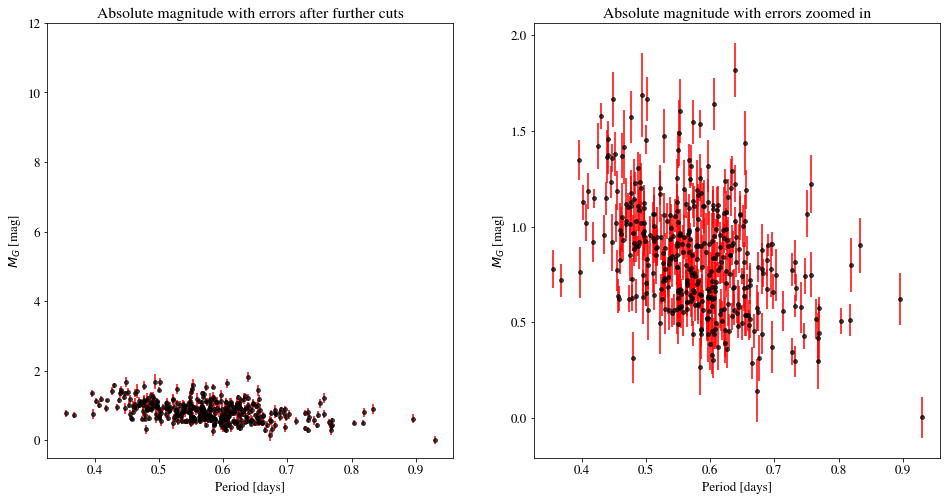

In [62]:
fig, axes = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(16.0, 8.0))

axes[0].scatter(new_period, new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
axes[0].vlines(new_period, ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')

axes[0].set_xlabel('Period [days]')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(-.5, 12)
axes[0].set_title('Absolute magnitude with errors after further cuts')

axes[1].scatter(new_period, new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
axes[1].vlines(new_period, ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')

axes[1].set_xlabel('Period [days]')
axes[1].set_ylabel('$M_G$ [mag]')
axes[1].set_title('Absolute magnitude with errors zoomed in')

We can see that by choosing a more stringent criteria with regards to the parallax over error and parallax measurement, we can exclude the higher $M_G$ outliers. We know that as the parallax increases, that the magnitude of the star increases since the relationship scales as
$$
M_G \propto \log_{10}{\left(\frac{\varpi}{1000}\right)}.
$$
Additionally, by excluding the stars with a lower value for the parallax over error, we exclude stars where the precision is lower and so the uncertainties are higher. This allows us to select only the most quality stars to determine the relation between period and luminosity more accurately.

Text(0.5, 1.0, 'Absolute magnitude with errors zoomed in')

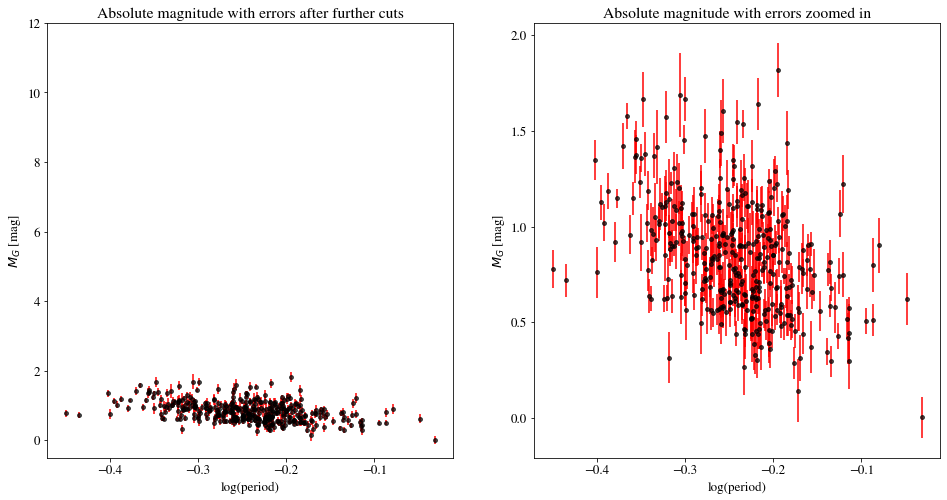

In [63]:
fig, axes = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(16.0, 8.0))

axes[0].scatter(np.log10(new_period), new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
axes[0].vlines(np.log10(new_period), ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')

axes[0].set_xlabel('log(period)')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(-.5, 12)
axes[0].set_title('Absolute magnitude with errors after further cuts')

axes[1].scatter(np.log10(new_period), new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
axes[1].vlines(np.log10(new_period), ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')

axes[1].set_xlabel('log(period)')
axes[1].set_ylabel('$M_G$ [mag]')
axes[1].set_title('Absolute magnitude with errors zoomed in')

# Bailor-Jones for DR2

Now, we perform the same routine as we did with the EDR3 catalogue but with the DR2 catalogue to see the similarities and differences. We see below that we have less points than the EDR3 catalogue. This could in part be due to the fact that the precision in parallax and parallax errors are greater in the EDR3 catalogue and so we have more reliable data that was not excluded in the C1 and C2 cuts from Lindegren.

In [64]:
dist_data2 = gaia_query("SELECT * FROM external.gaiadr2_geometric_distance as dist \
JOIN gaiadr2.gaia_source as dr2 ON dr2.source_id = dist.source_id \
JOIN gaiadr2.vari_rrlyrae as vari ON vari.source_id = dr2.source_id \
WHERE dr2.parallax_over_error > 5 \
AND dr2.parallax > 0.25 \
AND abs(dr2.b) > 30 \
AND vari.pf != 0;")

Text(0.5, 1.0, 'Calculated absolute magnitude from DR2 magnitudes and \nexternal.dr2_geometric_distance geometric distance catalogue with errors')

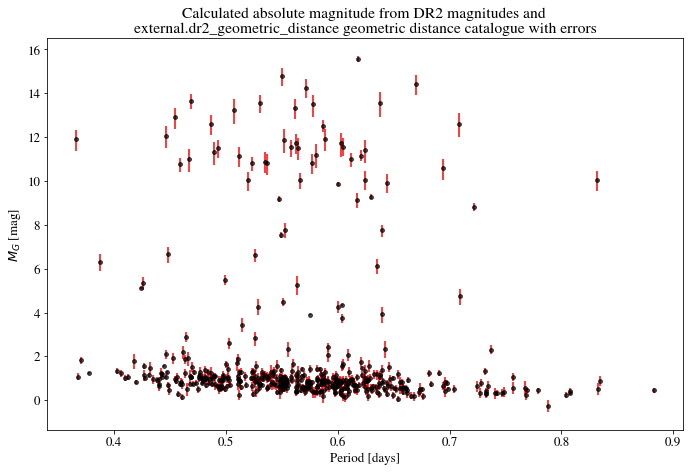

In [65]:
abs_mag_dr2 = dist_data2['phot_g_mean_mag']+5+5*np.log10(1/dist_data2['r_est'])
abs_mag_2_dr2 = dist_data2['phot_g_mean_mag']+5+5*np.log10(dist_data2['parallax']/1000)
low_mag_err_dr2 = dist_data2['phot_g_mean_mag']+5+5*np.log10(1/dist_data2['r_lo'])
hi_mag_err_dr2 = dist_data2['phot_g_mean_mag']+5+5*np.log10(1/dist_data2['r_hi'])

fig, ax = plt.subplots()

ax.scatter(dist_data2['pf'], abs_mag_dr2, color='k', alpha = 0.7, zorder=5, s=15.0)
ax.vlines(dist_data2['pf'], ymin=hi_mag_err_dr2, ymax=low_mag_err_dr2, color='r')

ax.set_xlabel('Period [days]')
ax.set_ylabel('$M_G$ [mag]')
ax.set_title('Calculated absolute magnitude from DR2 magnitudes and \nexternal.dr2_geometric_distance geometric \
distance catalogue with errors')

In [66]:
new_abs_mag_dr2 = []
new_period_dr2 = []
new_low_dr2 = []
new_hi_dr2 = []

for i in range(len(abs_mag_dr2)):
    
    max_val=np.max([1, np.exp(-0.2*(dist_data2['phot_g_mean_mag'][i]-19.0))])
    
    if np.sqrt(dist_data2['astrometric_chi2_al'][i]/(dist_data2['astrometric_n_good_obs_al'][i])) < 1.2*max_val and \
                                    dist_data2['parallax_over_error'][i]>16.27 and dist_data2['parallax'][i] < 0.8:
        
        if 1.0+0.015*dist_data2['bp_rp'][i]**2 < dist_data2['phot_bp_rp_excess_factor'][i] < \
                                                                 1.3+0.06*dist_data2['bp_rp'][i]**2:
            
            new_abs_mag_dr2.append(abs_mag_dr2[i])
            new_period_dr2.append(dist_data2['pf'][i])
            new_low_dr2.append(low_mag_err_dr2[i])
            new_hi_dr2.append(hi_mag_err_dr2[i])
            
new_low_dr2 = np.array(new_low_dr2)
new_hi_dr2 = np.array(new_hi_dr2)

Text(0.5, 1.0, 'Absolute magnitude with errors zoomed in')

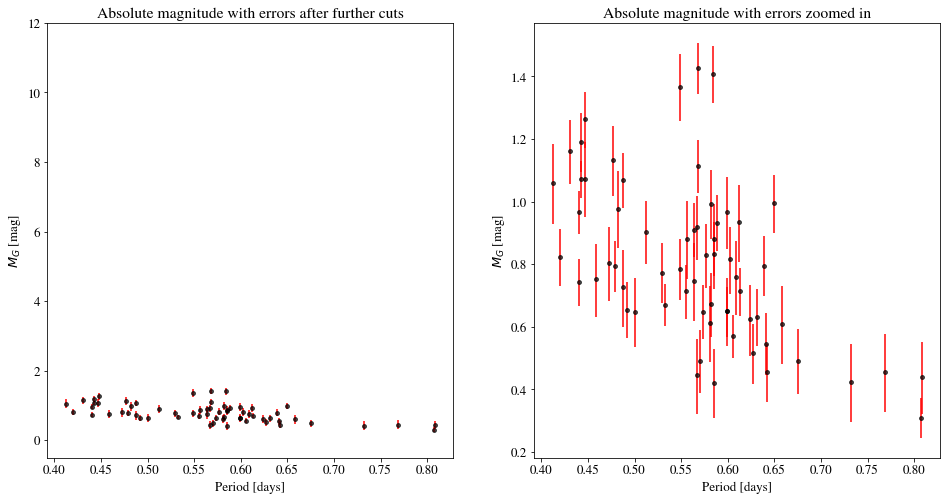

In [67]:
fig, axes = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(16.0, 8.0))

axes[0].scatter(new_period_dr2, new_abs_mag_dr2, color='k', alpha = 0.7, zorder=5, s=15.0)
axes[0].vlines(new_period_dr2, ymin=new_hi_dr2, ymax=new_low_dr2, color='r')

axes[0].set_xlabel('Period [days]')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(-.5, 12)
axes[0].set_title('Absolute magnitude with errors after further cuts')

axes[1].scatter(new_period_dr2, new_abs_mag_dr2, color='k', alpha = 0.7, zorder=5, s=15.0)
axes[1].vlines(new_period_dr2, ymin=new_hi_dr2, ymax=new_low_dr2, color='r')

axes[1].set_xlabel('Period [days]')
axes[1].set_ylabel('$M_G$ [mag]')
axes[1].set_title('Absolute magnitude with errors zoomed in')

# Basics of MH MCMC sampling

We have written a Metropolis-Hastings Markov Chain Monte Carlo simulator (MH) to sample from a Gaussian distribution so that we may then generalize our approach to sample from the posterior distribution of our period-magnitude data ponits. The MH algorithm works by creating a Markov Chain using a random walk in parameter space which selects parameters to plug into the likelihood function which when multiplied by our prior distribution is proportional to the posterior distribution according to Bayes' Theorem:

$$
\text{posterior}(\mathbf{\theta}) \propto \text{likelihood}(\mathbf{x}|\mathbf{\theta}) \times \text{prior}(\mathbf{\theta}).
$$

As this chain is generated, the sampler walks through parameter space finding which parameters will maximize the likelihood function (which is the same as minimizing $\chi^2$). If our MH converges properly, we will expect a histogram of our samples to match the analytic function. In our case, we sampled from a prior distribution centered at $\mu = 0$ and $\sigma = x_{candidate}$ to fit a Gaussian with $\mu = 1$ and $\sigma = 0.1$.

In [68]:
chain = mh_mcmc(gaussian, ln_gauss_llh, gaussian(1), 10000, 1000)

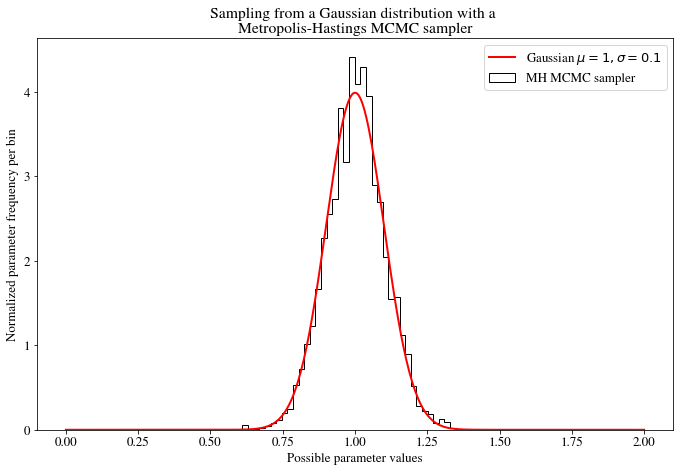

In [69]:
x = np.linspace(0, 2, 400)

fig, ax = plt.subplots()

ax.hist(chain[0], bins=40, density=True, histtype='step', label='MH MCMC sampler', color='k')
ax.plot(np.linspace(0, 2, 400), np.exp(-(x-1)**2/(2*0.1**2))/np.sqrt(2*np.pi*0.1**2), color='r', linewidth=2.0,
         label='Gaussian $\mu = 1, \sigma = 0.1$')
ax.set_xlabel('Possible parameter values')
ax.set_ylabel('Normalized parameter frequency per bin')
ax.set_title('Sampling from a Gaussian distribution with a \nMetropolis-Hastings MCMC sampler')

ax.legend()

Text(0.5, 1.0, 'x versus step number')

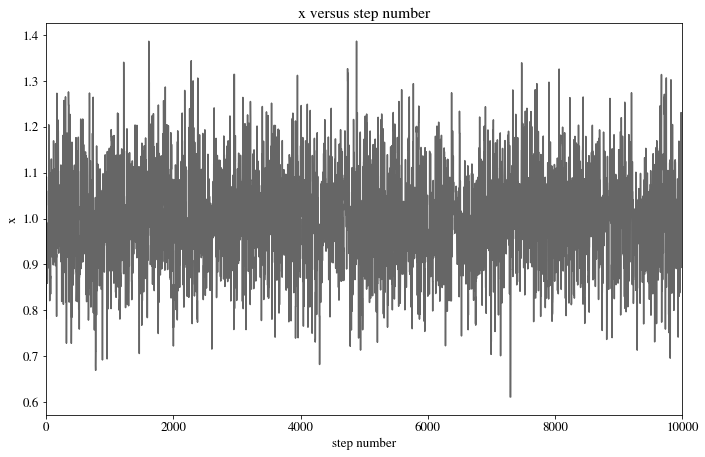

In [70]:
fig, ax = plt.subplots()

ax.plot(np.linspace(0, len(chain[0]), len(chain[0])), chain[0], color='k', alpha=0.6)
ax.set_xlim(0, len(chain[0]))
ax.set_xlabel('step number')
ax.set_ylabel('x')
ax.set_title('x versus step number')

Text(0.5, 1.0, 'Log($\\mathcal{L}$) as the chain continues to step')

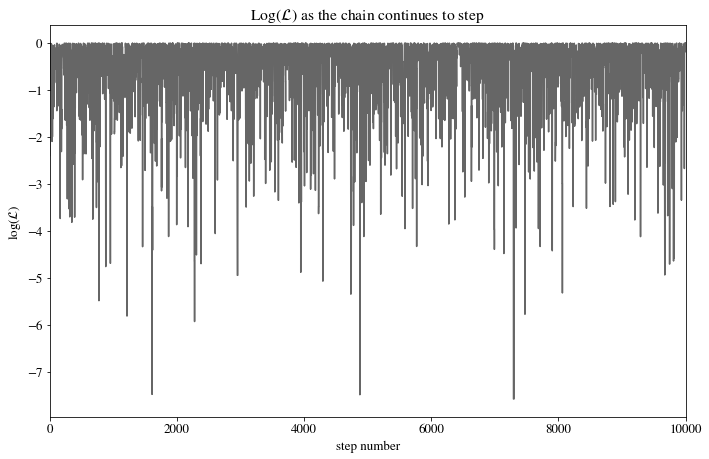

In [71]:
fig, ax = plt.subplots()

ax.plot(np.linspace(0, len(chain[1]), len(chain[1])), chain[1], color='k', alpha=0.6)
ax.set_xlim(0, len(chain[1]))
ax.set_xlabel('step number')
ax.set_ylabel('log($\mathcal{L}$)')
ax.set_title('Log($\mathcal{L}$) as the chain continues to step')

# Metropolis-Hastings MCMC sampling for our data

We would like to fit the model $M_G = a \times \log{(\frac{P}{day})} + b$ to the data which is a linear relation in $\log{P}$. This is done throughout the literature [M. Catelan, Barton J. Pritzl, and Horace A. Smith](https://iopscience.iop.org/article/10.1086/422916/pdf) and we see that the values are close to 0 for both $a$ and $b$ and so we assume that $a$ and $b$ are distributed in a normal distribution with $a$ being most likely negative, and $b$ being most likely negative as well but with more variability. As a result, our priors for these values are as follows:

$$
p(a) = \frac{1}{\sqrt{0.01\pi}}\exp{\left(\frac{-(x+3)^2}{0.01}\right)},
$$
and
$$
p(b) = \frac{1}{\sqrt{0.75\pi}}\exp{\left(\frac{-(x)^2}{0.75}\right)},
$$
where the uncertainty is the step-size we will use in our MCMC sampler. Now, we also must contend with the inherent scatter in the data itself. We see that it is not exactly linear but more blob like. As a result, we must also add into our model a parameter $\sigma_{scatter}$ which we add in quadrature in our log-likelihood estimation to our measurement errors. We must also fit for this error and again a normal distribution for this parameter below
$$
p(\sigma_{scatter}) = \frac{1}{\sqrt{0.3\pi}}\exp{\left(\frac{-(x-1)^2}{0.3}\right)}.
$$

We can see from our plots below that our MCMC sampler does converge as the log likelihood continues to stay closer to 0 meaning that the sampler does not walk too far from the global minima in parameter space. Additionally, we see that our potential value for $b$ oscillates rapidly between different values meaning that the sampler has found an ideal spot in parameter space to try different combinations of $a$ and $\sigma_{scatter}$ values which provides us with our other graph below in which we plot different model fits using 50 random sets of parameters obtained from our MCMC sampler.

In [72]:
multivar_params = [0.01, 0.2, 0.01]
multivar_params_mu = [-1.75,  0.5, 3.0]

def model_MG(params, data):
    
    a_arr = np.full(len(data), params[0])
    b_arr = np.full(len(data), params[1])
    model = a_arr*np.log10(data)+b_arr
    
    return model

<ipython-input-10-846835dd829c>:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x_t[burn_in:], acceptance_rate, log_likelihood])


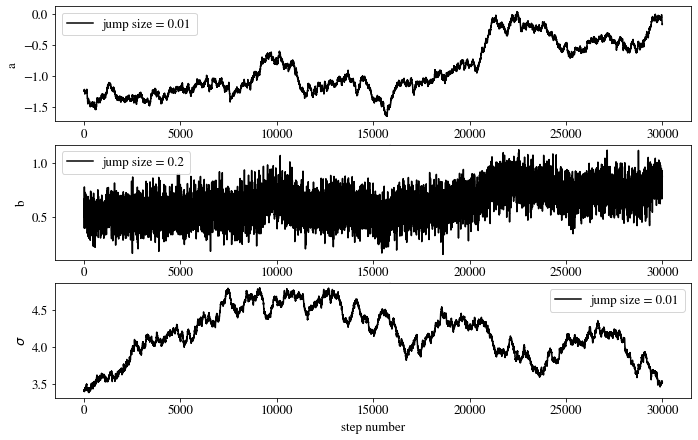

In [73]:
x_t_3 = MH_MCMC(posterior=likelihood, proposal=multivar_gauss, iters=50000, burn_in=20000,
                x0=multivar_gauss(multivar_params_mu),observed=new_abs_mag, model=model_MG, x_data=new_period,
                errors=new_sym_err, real_bool=True)

a_chain = np.zeros(len(x_t_3[0]))
b_chain = np.zeros(len(x_t_3[0]))
sigma_chain = np.zeros(len(x_t_3[0]))

t = 0
for coord in x_t_3[0]:

    a_chain[t] = coord[0]
    b_chain[t] = coord[1]
    sigma_chain[t] = coord[2]
    t+=1
    
acc_rate = []

step_num = np.linspace(0, len(x_t_3[0]), len(x_t_3[0]))
step_num_2 = np.linspace(0, len(x_t_3[1]), len(x_t_3[1]))

fig, axes = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 1]})

axes[0].plot(step_num, a_chain, color='k', label=f'jump size = {multivar_params[0]}')
axes[0].set_xlabel('step number')
axes[0].set_ylabel('a')
axes[1].plot(step_num, b_chain, color='k', label=f'jump size = {multivar_params[1]}')
axes[1].set_xlabel('step number')
axes[1].set_ylabel('b')
axes[2].plot(step_num, sigma_chain, color='k', label=f'jump size = {multivar_params[2]}')
axes[2].set_xlabel('step number')
axes[2].set_ylabel('$\sigma$')

axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

Text(0.5, 1.0, 'Log($\\mathcal{L}$) as the chain continues to step')

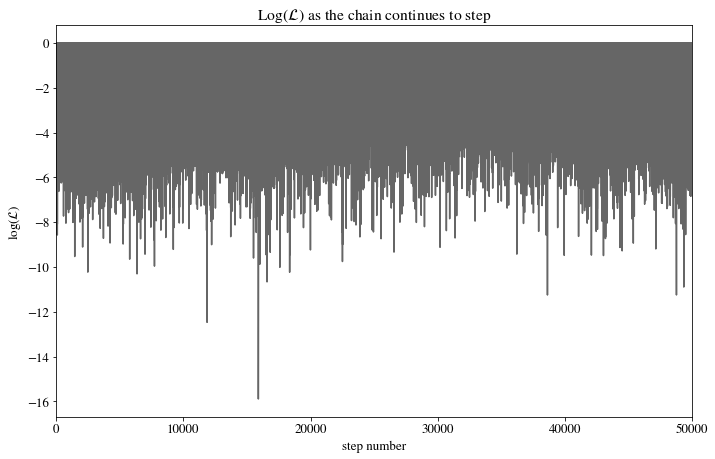

In [74]:
fig, ax = plt.subplots()

ax.plot(np.linspace(0, len(x_t_3[2]), len(x_t_3[2])), x_t_3[2], color='k', alpha=0.6)
ax.set_xlim(0, len(x_t_3[2]))
ax.set_xlabel('step number')
ax.set_ylabel('log($\mathcal{L}$)')
ax.set_title('Log($\mathcal{L}$) as the chain continues to step')

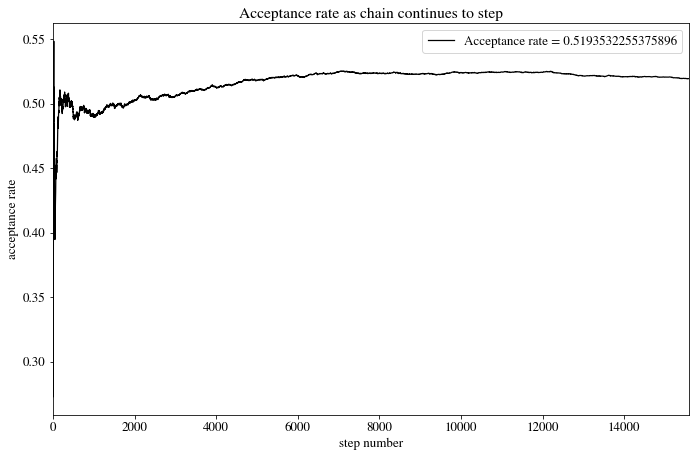

In [75]:
fig, ax = plt.subplots()

ax.plot(np.linspace(0, len(x_t_3[1]), len(x_t_3[1])),x_t_3[1], linewidth=1.25, color='k',
        label=f'Acceptance rate = {x_t_3[1][-1]}')
ax.set_xlim(-10, len(x_t_3[1])+10)
ax.set_xlabel('step number')
ax.set_ylabel('acceptance rate')
ax.set_title('Acceptance rate as chain continues to step')
ax.legend()

# Corner plot

We can see from the diagnostic graphs above that we were unable to get our sampler to converge. While we did get close to an acceptance fraction of $50\%$, we see that the only parameter which seemed to converge was $b$. It appears that $\sigma$ has the hardest time converging since it is not exactly being fit, but instead is only used when calculating the likelihood itself and not actually comparing the model with the data points. Lastly, we can see that $a$ somewhat converges around values which seem appropriate with our data and our plot of the spread below. We guess that it is possible that our code is at fault, but it could also be the algorithm itself. Other MCMC methods are used since they avoid the downsides of MH algorithms, specifically, the random element of the chain building aspect of the algorithm which may spend many steps in parameter space to converge. Additionally, it may be that our choices of priors were incorrect. We should expect, however, that with a properly built MH MCMC sampler, the sampler will eventually converge on a global extremal value and not leave that position or stray far from it.

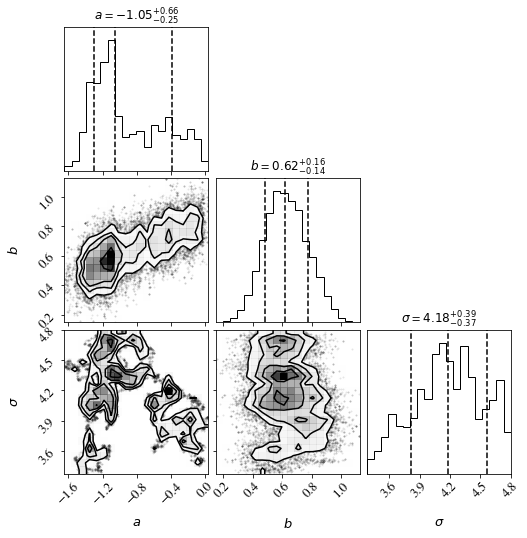

In [76]:
figure1 = corner.corner(x_t_3[0], labels=[r"$a$", r"$b$", r"$\sigma$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

# Does our model capture the data?

We can see after plotting 50 random parameter values obtained in the chain that our model does allow for scatter and captures almost all of the data points we have while mostly aggregating around the central blob of points. As a result, we claim that our model captures rather well the data present. Some possible adjustments we could make to the model would be to instead assume that our priors are uniformly distributed instead of normally distributed. We could also use a student's t-distribution which would allow for greater variability at the tails of the central maxima unlike a normal distribution.

In [77]:
params_arr = []

for n in range(len(x_t_3[0])):
    
    if n%600 == 0:
        
        params_arr.append(x_t_3[0][n])

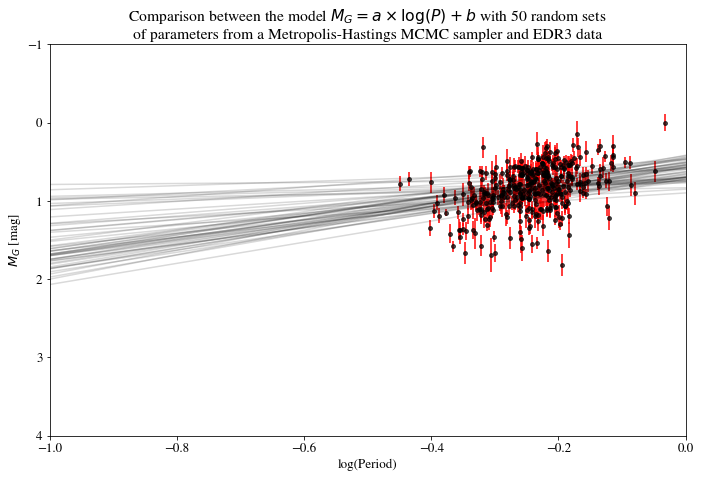

In [78]:
fig, ax = plt.subplots()

ax.scatter(np.log10(new_period), new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
ax.vlines(np.log10(new_period), ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')
ax.set_xlim(-1.00, 0.00)
ax.set_ylim(4.0, -1.0)
ax.set_xlabel('log(Period)')
ax.set_ylabel('$M_G$ [mag]')
ax.set_title('Comparison between the model $M_G = a \\times \\log{(P)} + b$ with 50 random sets\
\nof parameters from a Metropolis-Hastings MCMC sampler and EDR3 data')

for params in params_arr:
    
    ax.plot(np.log10(np.linspace(0.01, 1.0, 250)), params[0]*np.log10(np.linspace(0.01, 1.0, 250))+params[1],
            color='k', alpha=0.15)

In [79]:
model = pm.Model()

def M_G(a, b, x):
    
    mag = a*np.log10(x)+b
    
    return mag

with model:

    posterior = pm.Normal('posterior', mu=0.9, sd=1.0)
    
    a = pm.Normal("a", mu=multivar_params_mu[0], sd= multivar_params[0] )
    b = pm.Normal("b", mu=multivar_params_mu[1], sd= multivar_params[1] )
    sigma = pm.Normal("sigma", mu=multivar_params_mu[2], sd= multivar_params[2] )
    params = [a, b, sigma]
    model_val = M_G(params[0], params[1], new_period)
    
    logp = pm.Normal.dist(mu=model_val, sd=sigma**2).logp(posterior)

    pm.Potential('likelihood', logp)
    
    trace = pm.sample(2500)

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a, posterior]


/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 15 seconds.


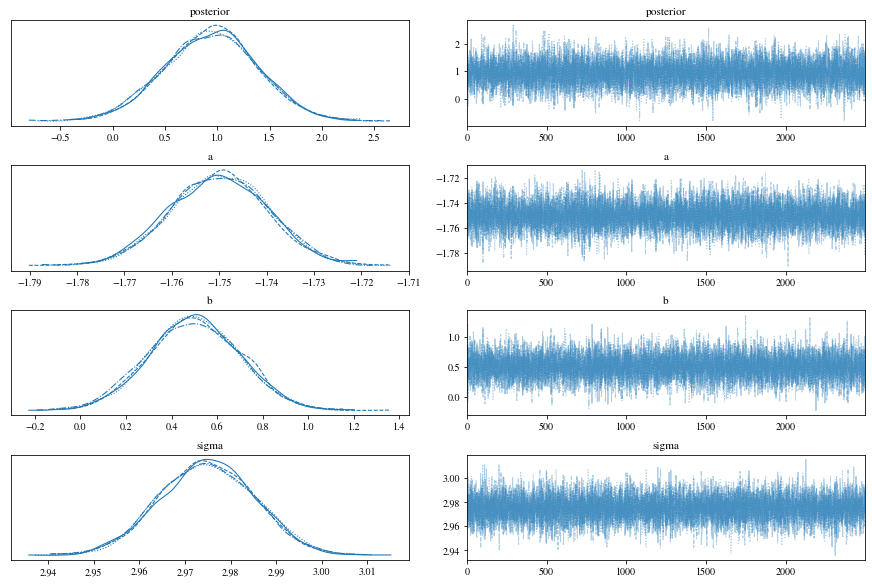

In [80]:
with model:
    
    traceplot(trace)

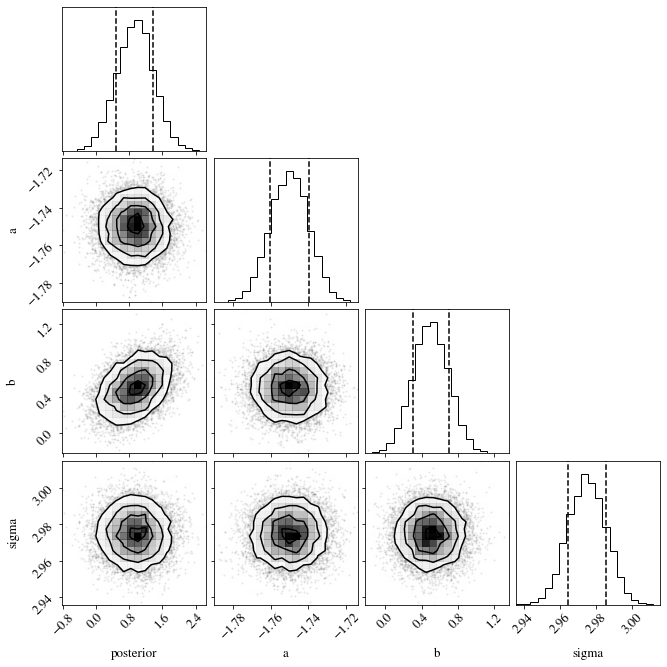

In [81]:
import corner
samples1 = pm.backends.tracetab.trace_to_dataframe(trace)
figure2 = corner.corner(samples1, quantiles=[0.16, 0.84])

In [82]:
model = pm.Model()

with model:
    
    a = pm.Normal("a", mu=multivar_params_mu[0], sd=multivar_params[0])
    b = pm.Normal("b", mu=multivar_params_mu[1], sd= multivar_params[1])
    sigma = pm.Normal("sigma", mu=multivar_params_mu[2], sd=multivar_params[2])
    
    M_G = pm.Normal("M_G",mu=b+a*np.log10(new_period),sigma = np.sqrt(sigma**2+(new_sym_err)**2),observed = new_abs_mag)
    
    trace= pm.sample(2500)

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 25 seconds.


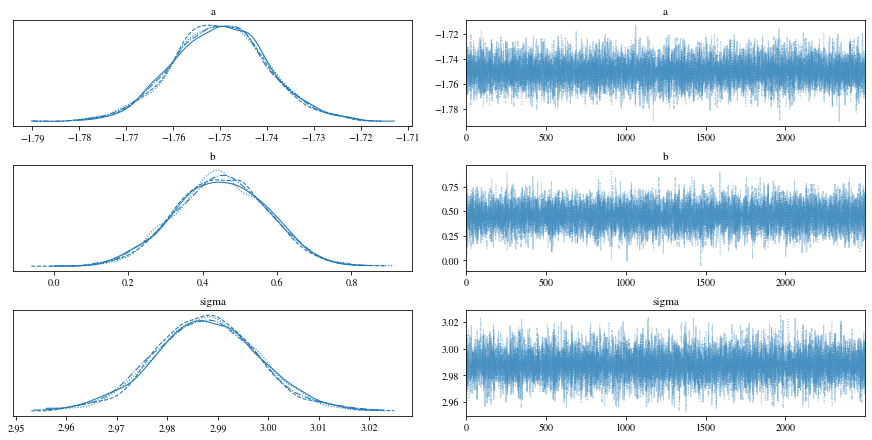

In [83]:
with model:
    
    traceplot(trace)

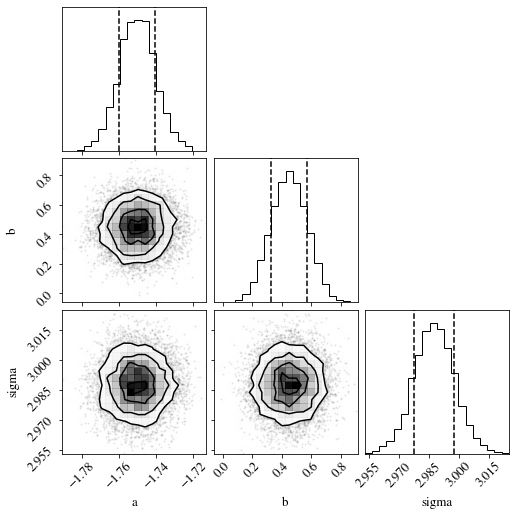

In [84]:
samples2 = pm.backends.tracetab.trace_to_dataframe(trace)
figure3 = corner.corner(samples2, quantiles=[0.16, 0.84])

# Total corner plot

We can see below that our corner plots do not show clean gaussian distributions except for $b$ which does appear to have a gaussian shape. This is due to our hand-coded MCMC sampler being unable to converge on values for $a$ and $\sigma$. Despite this, though, we do see that there is some sort of overall normal distribution when we superimpose our data on top of each other. Thus, we can say that these parameters do seem to show some sort of extremal value on which the samplers all converge upon.

In [85]:
df_dict = {'a': samples1['a'], 'b': samples1['b'], 'sigma': samples1['sigma']}
samples1 = pd.DataFrame(data=df_dict)

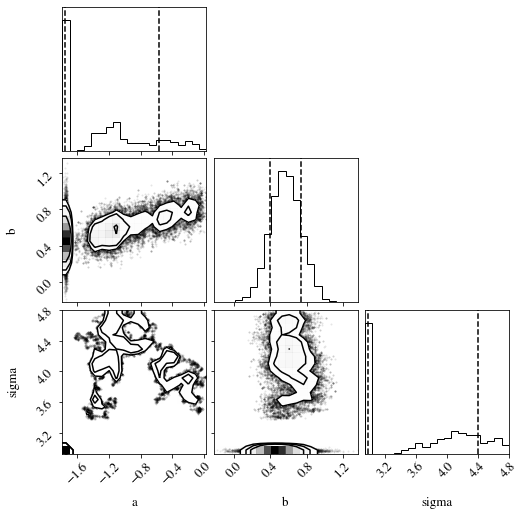

In [86]:
df_tot_dict = {'a': np.concatenate((a_chain, samples1['a'], samples2['a'])),
               'b': np.concatenate((b_chain, samples1['b'], samples2['b'])),
               'sigma': np.concatenate((sigma_chain, samples1['sigma'], samples2['sigma']))}
df_tot = pd.DataFrame(data=df_tot_dict)

figure = corner.corner(df_tot, quantiles=[0.16, 0.84])

In [87]:
wise_data = gaia_query("SELECT * FROM gaiadr2.allwise_best_neighbour as wise_nbor \
JOIN gaiadr1.allwise_original_valid as wise_val ON wise_val.allwise_oid = wise_nbor.allwise_oid \
JOIN gaiaedr3.dr2_neighbourhood as nbor ON wise_nbor.source_id = nbor.dr2_source_id \
JOIN gaiaedr3.gaia_source as edr3 ON edr3.source_id = nbor.dr3_source_id \
JOIN gaiadr2.vari_rrlyrae as vari on vari.source_id = nbor.dr2_source_id \
WHERE edr3.parallax > 0.25 \
AND edr3.parallax_over_error > 5 \
AND ABS(edr3.b) > 30 \
AND vari.pf != 0;")

(16.0, 8.0)

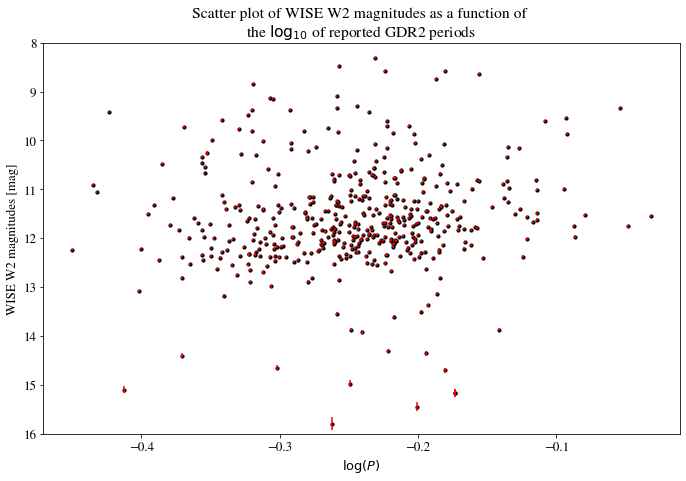

In [88]:
plt.scatter(x=np.log10(wise_data['pf']), y=wise_data['w2mpro'], s=10.0, color='k')
plt.vlines(x=np.log10(wise_data['pf']), ymin=wise_data['w2mpro']-wise_data['w2mpro_error'],
                      ymax=wise_data['w2mpro']+wise_data['w2mpro_error'], color='r')
plt.xlabel('$\log{(P)}$')
plt.ylabel('WISE W2 magnitudes [mag]')
plt.title('Scatter plot of WISE W2 magnitudes as a function of \nthe $\log_{10}{}$ of reported GDR2 periods')
plt.ylim(16, 8)

In [89]:
new_abs_mag = []
new_period = []
new_sym_err = []

for i in range(len(wise_data['pf'])):
    
    max_val=np.max([1, np.exp(-0.2*(wise_data['phot_g_mean_mag'][i]-19.0))])
    
    if np.sqrt(wise_data['astrometric_chi2_al'][i]/(wise_data['astrometric_n_good_obs_al'][i])) < 1.2*max_val and \
                                    wise_data['parallax_over_error'][i]>15 and wise_data['parallax'][i] < 0.6:
            
            new_abs_mag.append(wise_data['w2mpro'][i])
            new_period.append(wise_data['pf'][i])
            new_sym_err.append(wise_data['w2mpro_error'][i])

new_abs_mag = np.array(new_abs_mag)
new_period = np.array(new_period)
new_sym_err = np.array(new_sym_err)

(13.5, 10.0)

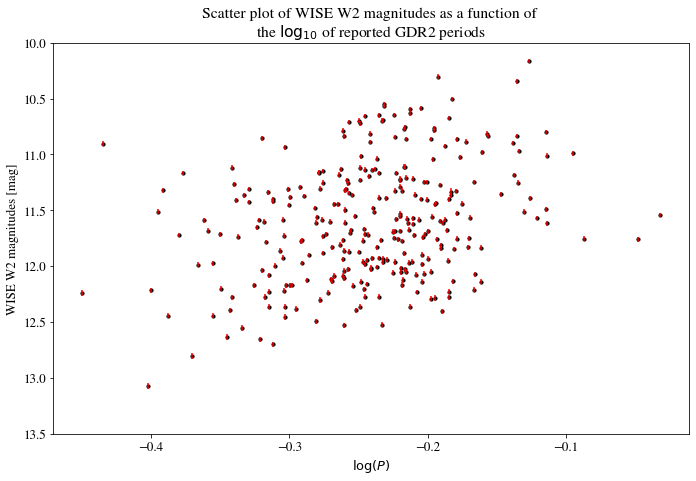

In [90]:
plt.scatter(x=np.log10(new_period), y=new_abs_mag, s=10.0, color='k')
plt.vlines(np.log10(new_period), ymin=new_abs_mag-new_sym_err, ymax=new_abs_mag+new_sym_err, color='r')
plt.xlabel('$\log{(P)}$')
plt.ylabel('WISE W2 magnitudes [mag]')
plt.title('Scatter plot of WISE W2 magnitudes as a function of \nthe $\log_{10}{}$ of reported GDR2 periods')
plt.ylim(13.5, 10)

In [91]:
model = pm.Model()

with model:
    
    a = pm.Normal("a", mu=-2, sd=0.1)
    b = pm.Normal("b", mu=10, sd=1)
    sigma = pm.Exponential("sigma", lam=10)
    
    M_G = pm.Normal("M_G",mu=b+a*np.log10(new_period),sigma = np.sqrt(sigma**2+(new_sym_err)**2),
                    observed = new_abs_mag)
    
    trace= pm.sample(2500)

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
INFO:pymc3:NUTS: [sigma, b, a]


/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 9 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 

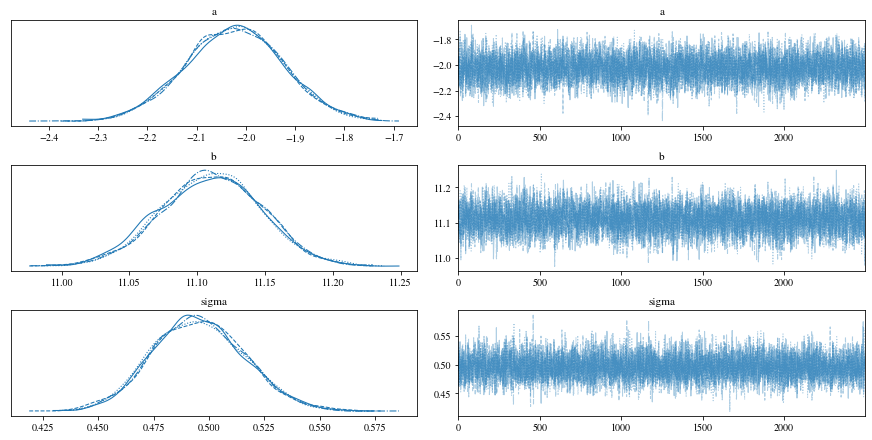

In [92]:
with model:
    
    traceplot(trace)

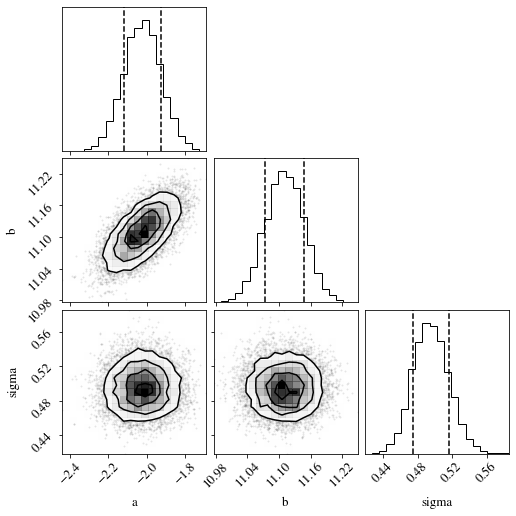

In [93]:
samples = pm.backends.tracetab.trace_to_dataframe(trace)
figure = corner.corner(samples, quantiles=[0.16, 0.84])

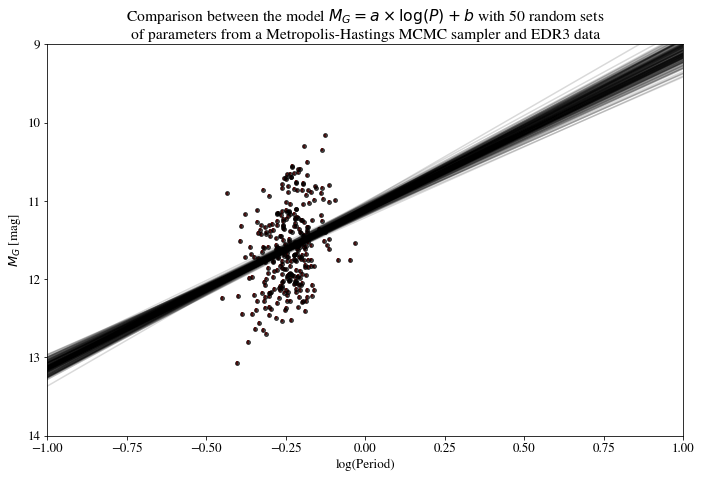

In [94]:
params_arr = []

for n in range(len(samples['a'])):
    
    if n%50 == 0:
        
        params_arr.append([samples['a'][n], samples['b'][n], samples['sigma'][n]])
        
fig, ax = plt.subplots()

ax.scatter(np.log10(new_period), new_abs_mag, color='k', alpha = 0.7, zorder=5, s=15.0)
ax.errorbar(np.log10(new_period), new_abs_mag, new_sym_err, color='r', linestyle='')
ax.set_xlim(-1.00, 1.0)
ax.set_ylim(14, 9.0)
ax.set_xlabel('log(Period)')
ax.set_ylabel('$M_G$ [mag]')
ax.set_title('Comparison between the model $M_G = a \\times \\log{(P)} + b$ with 50 random sets\
\nof parameters from a Metropolis-Hastings MCMC sampler and EDR3 data')

for params in params_arr:
    
    ax.plot(np.log10(np.linspace(0.001, 10, 250)), params[0]*np.log10(np.linspace(0.001, 10, 250))+params[1],
            color='k', alpha=0.15)

# Optical vs. Infrared

We see in the near-infrared map that the scatter of data points is much greater than the scatter in the optical region. Additionally, the slope of the near-infrared fit is more negative than the slope of the optical fit. Furthermore, the errors in the near-infrared region are much less than the errors in the optical region. This could be due to the fact that near-infrared photons are not scattered nearly as much by dust particles compared to the photons in the optical region. We also see that the magnitude in the near-infrared region is much higher and the log-periods are much closer to $-0.25$ whereas the optical magnitude is lower and the log-periods, although centered around $-0.25$ seem to spread further away from that point. Lastly, there appears to be an downward trend in magnitude as one moves from higher log-periods to lower log-periods in the near-infrared plot as opposed to the optical plot which does not contain any such trend.

In [95]:
pbmfoe = []
prmfoe = []
bp_rp = []
period = []

for i in range(len(dist_data)):
    
    max_val=np.max([1, np.exp(-0.2*(dist_data['phot_g_mean_mag'][i]-19.0))])
    
    if np.sqrt(dist_data['astrometric_chi2_al'][i]/(dist_data['astrometric_n_good_obs_al'][i])) < 1.2*max_val and \
                                    dist_data['parallax_over_error'][i]>20:
        
        if 1.0+0.015*dist_data['bp_rp'][i]**2 < dist_data['phot_bp_rp_excess_factor'][i] < \
                                                                 1.3+0.06*dist_data['bp_rp'][i]**2:
        
            pbmfoe.append(dist_data['phot_bp_mean_flux_over_error'][i])
            prmfoe.append(dist_data['phot_rp_mean_flux_over_error'][i])
            bp_rp.append(dist_data['bp_rp'][i])
            period.append(dist_data['pf'][i])

pbmfoe = np.array(pbmfoe)
prmfoe = np.array(prmfoe)
log_per = np.log10(period)

sigma_bp = 2.5*np.log10(1+1/pbmfoe)
sigma_rp = 2.5*np.log10(1+1/prmfoe)

err = np.sqrt(sigma_bp**2+sigma_rp**2)

Text(0.5, 1.0, 'Absolute magnitude with errors zoomed in')

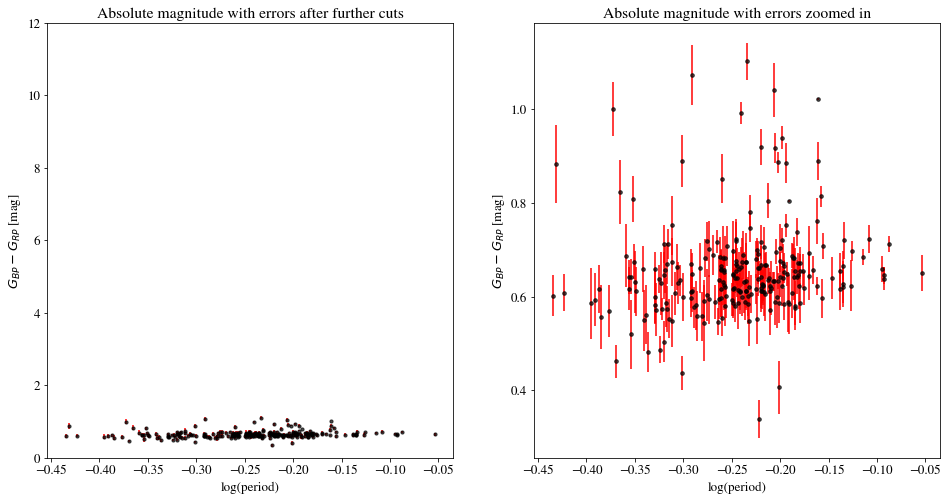

In [96]:
fig, axes = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(16.0, 8.0))

axes[0].scatter(log_per, bp_rp, color='k', alpha = 0.7, zorder=5, s=10.0)
axes[0].vlines(x=log_per, ymin=bp_rp-err, ymax=bp_rp+err, color='r')
axes[0].set_ylim(0.0, 12.0)

axes[0].set_xlabel('log(period)')
axes[0].set_ylabel('$G_{BP} - G_{RP}$ [mag]')
axes[0].set_title('Absolute magnitude with errors after further cuts')

axes[1].scatter(log_per, bp_rp, color='k', alpha = 0.7, zorder=5, s=13.0)
axes[1].vlines(log_per, ymin=bp_rp-err, ymax=bp_rp+err, color='r')

axes[1].set_xlabel('log(period)')
axes[1].set_ylabel('$G_{BP} - G_{RP}$ [mag]')
axes[1].set_title('Absolute magnitude with errors zoomed in')

In [97]:
a = None
b = None
sigma_scat = None

model = pm.Model()

with model:
    
    a = pm.Normal("a", mu=0.05, sd= 0.01 )
    b = pm.Normal("b", mu=0.5, sd= 0.1 )
    sigma_scat = pm.Normal("sigma", mu=0.1, sd=0.001 )
    
    M_G = pm.Normal("M_G",mu=b+a*log_per, sigma = np.sqrt(sigma_scat**2+err**2),observed = bp_rp)
    
    trace= pm.sample(2500)

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
INFO:pymc3:NUTS: [sigma, b, a]


/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took

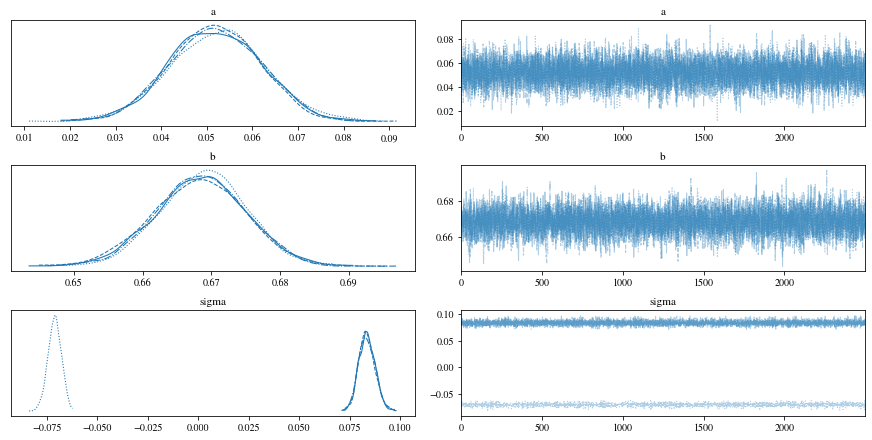

In [98]:
with model:
    
    traceplot(trace)

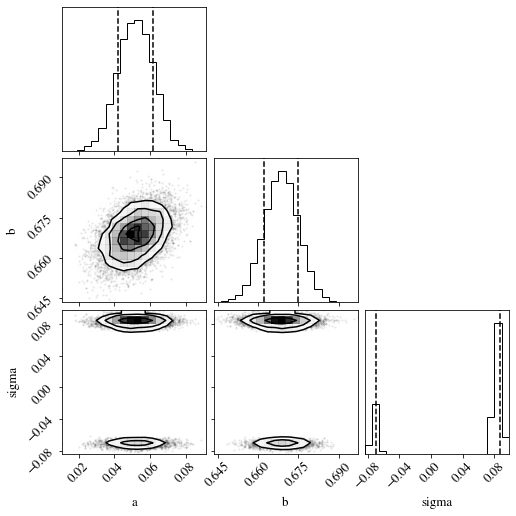

In [99]:
import corner
samples = pm.backends.tracetab.trace_to_dataframe(trace)
_ = corner.corner(samples, quantiles=[0.16, 0.84])

In [100]:
a = np.mean(trace['a'])
b = np.mean(trace['b'])

Text(0.5, 1.0, 'Absolute magnitude with errors zoomed in')

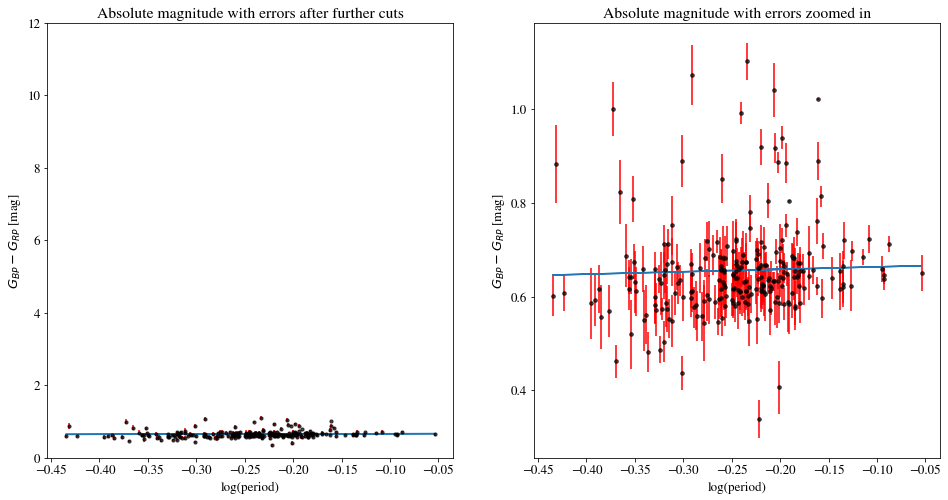

In [101]:
fig, axes = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(16.0, 8.0))

axes[0].scatter(log_per, bp_rp, color='k', alpha = 0.7, zorder=5, s=10.0)
axes[0].vlines(x=log_per, ymin=bp_rp-err, ymax=bp_rp+err, color='r')
axes[0].plot(log_per, a*log_per+b)
axes[0].set_ylim(0.0, 12.0)

axes[0].set_xlabel('log(period)')
axes[0].set_ylabel('$G_{BP} - G_{RP}$ [mag]')
axes[0].set_title('Absolute magnitude with errors after further cuts')

axes[1].scatter(log_per, bp_rp, color='k', alpha = 0.7, zorder=5, s=13.0)
axes[1].vlines(log_per, ymin=bp_rp-err, ymax=bp_rp+err, color='r')
axes[1].plot(log_per, a*log_per+b)

axes[1].set_xlabel('log(period)')
axes[1].set_ylabel('$G_{BP} - G_{RP}$ [mag]')
axes[1].set_title('Absolute magnitude with errors zoomed in')

In [102]:
rr_lyrae_data = gaia_query("SELECT * FROM gaiadr2.gaia_source JOIN gaiadr2.vari_rrlyrae USING (source_id) \
WHERE pf IS NOT NULL \
AND g_absorption IS NOT NULL;", async_bool=True)

In [103]:
color_excess = np.zeros(len(rr_lyrae_data))

for i in range(len(color_excess)):
    
    color_excess[i] = rr_lyrae_data['bp_rp'][i] - a*np.log10(rr_lyrae_data['pf'][i])+b

<ipython-input-103-5daba5ba0a4b>:5: UserWarning: Warning: converting a masked element to nan.
  color_excess[i] = rr_lyrae_data['bp_rp'][i] - a*np.log10(rr_lyrae_data['pf'][i])+b


Using our calculated color excess values, we can now calculate the $A_{G}$ value also known as the extinction value for each RR Lyrae variable using the formula:

$$
R_G \equiv \frac{A_G}{E(G_{BP} - G_{RP})} = 2.0
$$

In [104]:
extinction = np.zeros(len(rr_lyrae_data))

for i in range(len(color_excess)):
    
    extinction[i] = 2.0*color_excess[i]

In [105]:
err_col_exc = extinction - rr_lyrae_data['g_absorption']
rel_err_col_exc = np.abs(extinction - rr_lyrae_data['g_absorption'])/np.abs(rr_lyrae_data['g_absorption'])

(-20.0, 10.0)

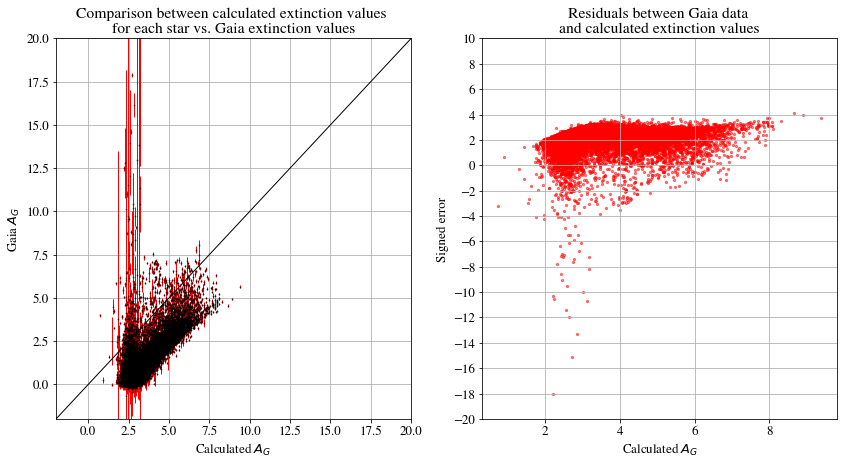

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [2,2]}, figsize=(14.0, 7.0))

axes[0].scatter(extinction, rr_lyrae_data['g_absorption'], color='k', alpha=0.5, s=1.0, zorder=20)
axes[0].vlines(extinction, rr_lyrae_data['g_absorption']-rr_lyrae_data['g_absorption_error'],
              rr_lyrae_data['g_absorption']+rr_lyrae_data['g_absorption_error'], color='r', linewidth=1.0)
axes[0].plot(np.linspace(-2, 20, 2), np.linspace(-2, 20, 2), color='k', linewidth=1.0)
axes[0].grid(b=True, which='major')
axes[0].set_xlim(-2, 20)
axes[0].set_ylim(-2, 20)

axes[0].set_xlabel('Calculated $A_G$')
axes[0].set_ylabel('Gaia $A_G$')
axes[0].set_title('Comparison between calculated extinction values \nfor each star vs. Gaia extinction values')

axes[1].scatter(extinction, err_col_exc, color='r', s=5.0, alpha=0.5)
axes[1].grid(b=True, axis='both')
axes[1].set_yticks(np.linspace(-20, 20, 21))
axes[1].set_xlabel('Calculated $A_G$')
axes[1].set_ylabel('Signed error')
axes[1].set_title('Residuals between Gaia data \nand calculated extinction values')

axes[1].set_ylim(-20, 10)

In [198]:
new_long = np.zeros(len(rr_lyrae_data))

for i in range(len(rr_lyrae_data)):
    
    long = rr_lyrae_data['l'][i]
    
    if long > 180:
        
        new_long[i] = -(long - 360)
        
    else:
        
        new_long[i] = -long

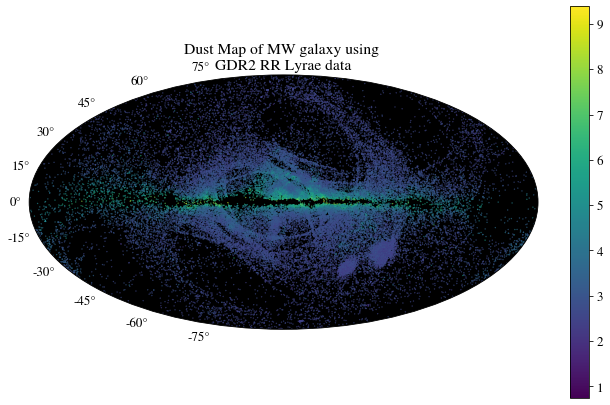

In [151]:
params = {"xtick.color" : "w"}
plt.rcParams.update(params)
cmap = col.Colormap('hot', 256)

plt.figure()
plt.subplot(111, facecolor='k', projection='aitoff')
plt.scatter(new_lat*np.pi/180, rr_lyrae_data['b']*np.pi/180, c=extinction, cmap='viridis', s=0.1, alpha=1.0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title("Dust Map of MW galaxy using \nGDR2 RR Lyrae data")
plt.colorbar()

In [229]:
extinction_copy = []
lat_copy = []
long_copy = []

mean = np.nanmean(color_excess)
std = np.nanstd(color_excess)

for i in range(len(extinction)):
    
    if mean-0.6*std < color_excess[i] < mean+std and \
    rr_lyrae_data['phot_rp_mean_flux_over_error'][i] > 20 and rr_lyrae_data['phot_bp_mean_flux_over_error'][i] > 20:
        
        extinction_copy.append(extinction[i])
        long_copy.append(new_long[i]*np.pi/180)
        lat_copy.append(rr_lyrae_data['b'][i]*np.pi/180)
        
print(len(long_copy))

18105


Text(0.5, 1.0, 'Dust Map of MW galaxy using \nGDR2 RR Lyrae data')

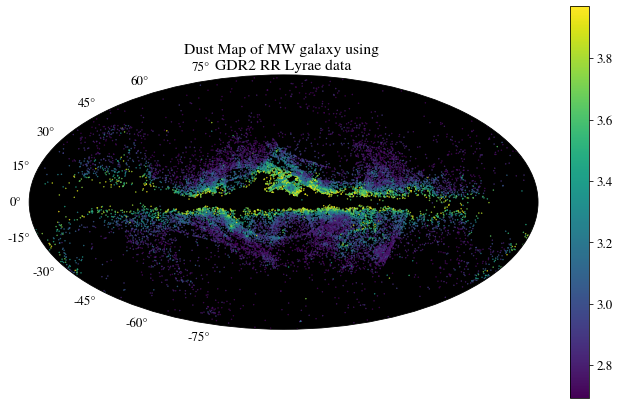

In [233]:
params = {"xtick.color" : "w"}
plt.rcParams.update(params)
background = col.Colormap('RdPu', 256)

plt.figure()
plt.subplot(111, facecolor='k', projection='aitoff')
plt.scatter(long_copy, lat_copy, c=extinction_copy, cmap='viridis', s=0.2  , alpha=1.0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.colorbar()
plt.title("Dust Map of MW galaxy using \nGDR2 RR Lyrae data")

# plt.savefig("dust_map.png", dpi=250)

# Distribution of RR Lyrae and our dust map

We notice that RR Lyrae are not distributed evenly throughout our map. This is due to the fact that RR Lyrae stars must have the right initial mass and since they have evolved off of the main sequence they must be of the right age, specifically, they must be older stars. This means that we might be unable to see dust in regions where dust exists if there are new stars forming or stars that are still on the main sequence and have not evolved off yet.

We notice that Taurus and Perseus regions are present, but we do not see much structure in that area. Similarly, we can see that the Cepheus and Cygnus regions are present, but again we do not see much small-scale structure. The Ophiucus region is clearly defined and we can see the smaller scale structure as well as the Lupus region. Additionally, the Chameleon region is somewhat present, but it does appear that there is background noise there making it hard to see. The Vela region is clearly seen as well. Lastly, it is ahrd to tell that the Monoceros and Orion regions are there. The regions with latitudes in the $\theta > 150$ and $\theta < -150$ range are lacking in stars in our original data and so our methodology may be what is causing these structures to be absent from our dust map.

Text(0.5, 1.0, 'SFD E(B-V) map')

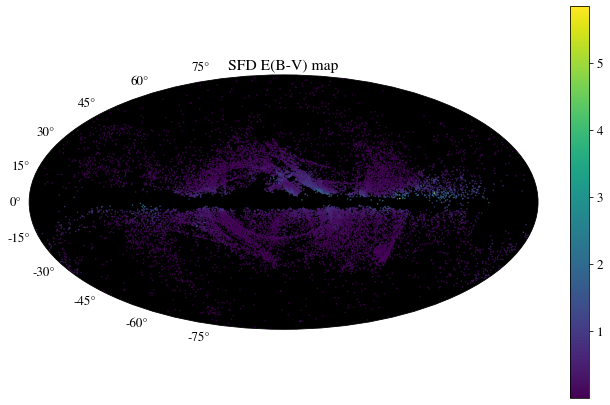

In [230]:
coords = SkyCoord(np.array(long_copy)*180/np.pi, np.array(lat_copy)*180/np.pi, unit='deg', frame='galactic')

sfd = SFDQuery()
AG_sfd = sfd(coords)



params = {"xtick.color" : "k"}
plt.rcParams.update(params)
background = col.Colormap('RdPu', 256)

plt.figure()
plt.subplot(111, facecolor='k', projection='aitoff')
plt.scatter(long_copy, lat_copy, c=AG_sfd, cmap='viridis', s=0.2  , alpha=1.0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.colorbar()
plt.title("SFD E(B-V) map")

# SFD vs. Our Map

Should we expect our map to look identical to the SFD map? No, we should not expect it to look identical. The SFD map is composed using CMB radiation while our map is composed using RR Lyrae variables. This makes a difference in multiple ways. First, CMB radiation is uniform in its distance from earth and so the amount of dust at each column protruding from the observer out to the CMB is the amount of dust at each column protruding from the observer out to the last scattering surface. For the RR Lyrae map, the amount of dust is the integrated amount from the observer to the star. Since the distribution of RR Lyrae is not uniform in distance from the observer to the stars, we might expect the amount of dust in the SFD map to be greater compared to our map. Building on this point, RR Lyrae variables are not evenly distributed throughout the sky and since we are using RR Lyraes to measure dust, if there is a point in the sky at which an RR Lyrae does not occupy or if other structures obscure the variable, then we will not be able to measure any dust there. Moreover, the datasets used in creating the SFD map were not Gaia datasets, but data gathered from IRAS and DIRBE datasets, so this data may have been collected in a different manner and certain other values which were calculated using this data may be different from the same quantities calculated using the Gaia data. Moreover, the SFD map takes into account different background sources that may obscure the actual dust distribution and so if these errors are not taken into account accurately or are handled in a way that makes creating the map a feasible process, then the map may look different from our map which takes into account different factors. Similarly, if our account of background sources is not entirely accurate, we may generate a map which is flawed and can look different from the SFD map.